In [114]:
import os
import sys
import glob
import json
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/global/homes/r/romo/repos/BACON_romo/')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 12

In [175]:
import re

evts_path = '/pscratch/sd/r/romo/bacon_data_npz/'

trigger_chs = [9, 10, 11]
normal_chs  = range(9)

thr_ADC        = 50
sg_filt_window = 30
min_dist       = 15

def extract_date_and_number(filename):
    #print(filename)
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

files      = os.listdir(evts_path)
filt_files = sorted(glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_w{sg_filt_window}_dist{min_dist}_run-*'), key=extract_date_and_number)

In [176]:
filt_files;

In [177]:
all_dates = []
for filename in filt_files:
    date, _ = extract_date_and_number(filename)
    if date in ['09_08_2024', '09_09_2024']:
        continue
    elif date in all_dates:
        continue
    else:
        all_dates.append(date)

In [178]:
all_dates

['09_10_2024',
 '09_11_2024',
 '09_12_2024',
 '09_20_2024',
 '09_25_2024',
 '09_28_2024',
 '10_04_2024',
 '10_11_2024',
 '10_17_2024',
 '10_25_2024',
 '11_01_2024',
 '11_11_2024']

In [179]:
idx_peak_thr_trigg_all = {}
h_peak_sg_d_trigg_all  = {}

for date in all_dates:
    print(date)
    date_files20 = sorted(glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_w{sg_filt_window}_dist{min_dist}_run-{date}*'), key=extract_date_and_number)[:20]
    for ifile,filename in enumerate(date_files20):
        d = np.load(filename, allow_pickle=True)
    
        if date not in idx_peak_thr_trigg_all:
            idx_peak_thr_trigg_all[date] = {ch: [] for ch in trigger_chs}
            h_peak_sg_d_trigg_all [date] = {ch: [] for ch in trigger_chs}
    
        for ch in trigger_chs:
            idx_peak_thr_trigg_all[date][ch].append(d['idx_peaks_thr_ch_trigg_dict']         .item()[ch])
            h_peak_sg_d_trigg_all [date][ch].append(d['height_peaks_sg_deconv_ch_trigg_dict'].item()[ch])

# Now concatenate all collected arrays for each channel
for date in idx_peak_thr_trigg_all.keys():
    for ch in trigger_chs:
        idx_peak_thr_trigg_all[date][ch] = np.concatenate(idx_peak_thr_trigg_all[date][ch])
        h_peak_sg_d_trigg_all [date][ch] = np.concatenate(h_peak_sg_d_trigg_all [date][ch])

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024


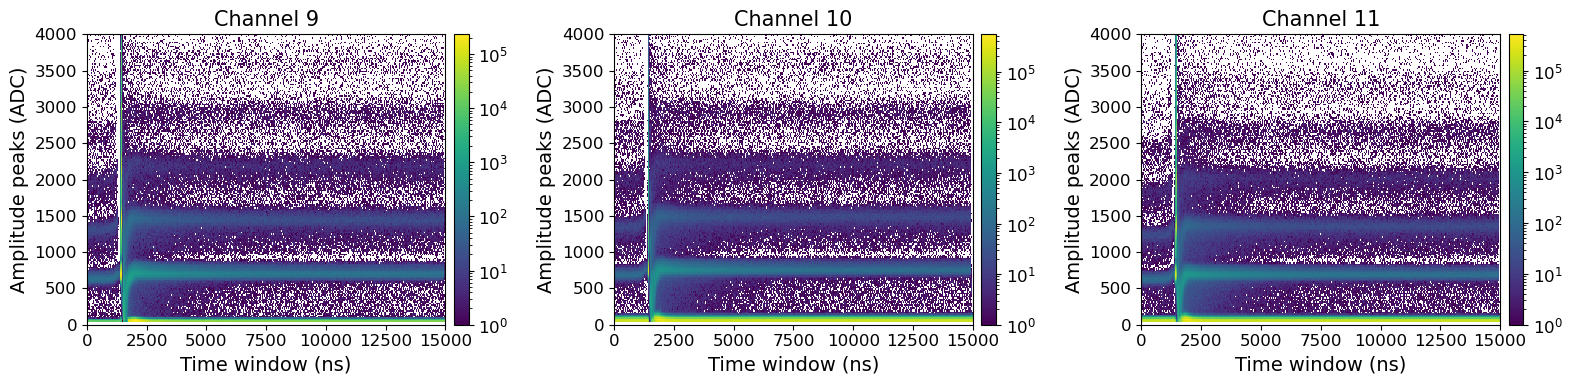

In [180]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k in [9, 10, 11]:
    j = k%3

    ch_idxs = np.concatenate(([np.concatenate((idx_peak_thr_trigg_all[date][k])) for date in idx_peak_thr_trigg_all.keys()]))
    ch_vals = np.concatenate(([np.concatenate((h_peak_sg_d_trigg_all [date][k])) for date in idx_peak_thr_trigg_all.keys()]))
    
    fig0 = axs[j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 4000)), cmin=1, norm=LogNorm())
    axs[j].set_xlabel('Time window (ns)',      fontsize=14)
    axs[j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    fig.colorbar(fig0[3], ax=axs[j], pad=0.02)
plt.tight_layout()
plt.show()

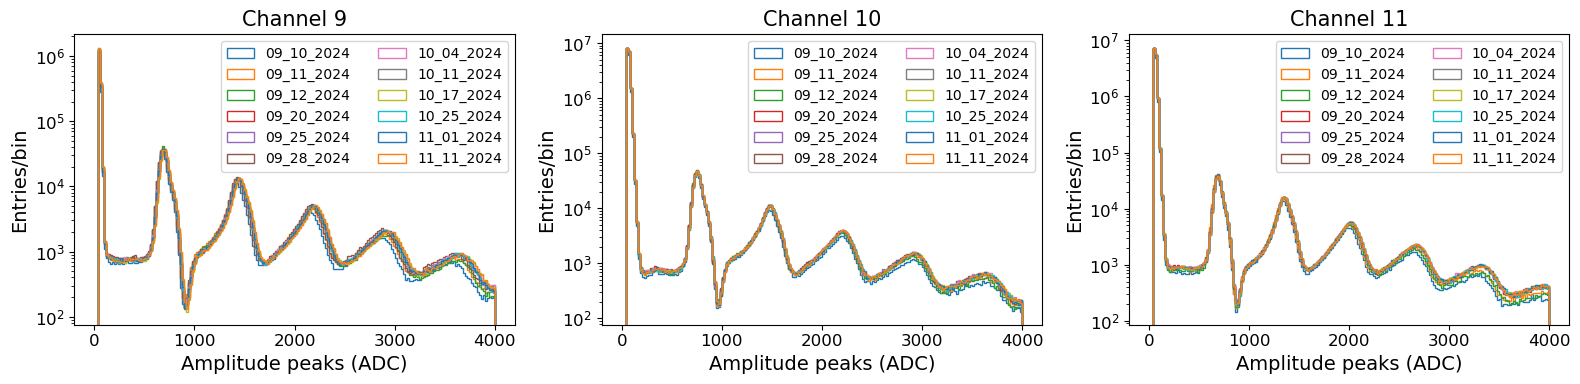

In [181]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k in [9, 10, 11]:
    j = k%3
    for date in all_dates:
        ch_vals = np.concatenate((np.concatenate(([h_peak_sg_d_trigg_all[date][k]]))))
        axs[j].hist(ch_vals, 200, range=(0, 4000), histtype='step', label=f'{date}')
    axs[j].set_ylabel('Entries/bin',           fontsize=14)
    axs[j].set_xlabel('Amplitude peaks (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    axs[j].set_yscale('log')
    axs[j].legend(fontsize=10, ncol=2)
plt.tight_layout()
plt.show()

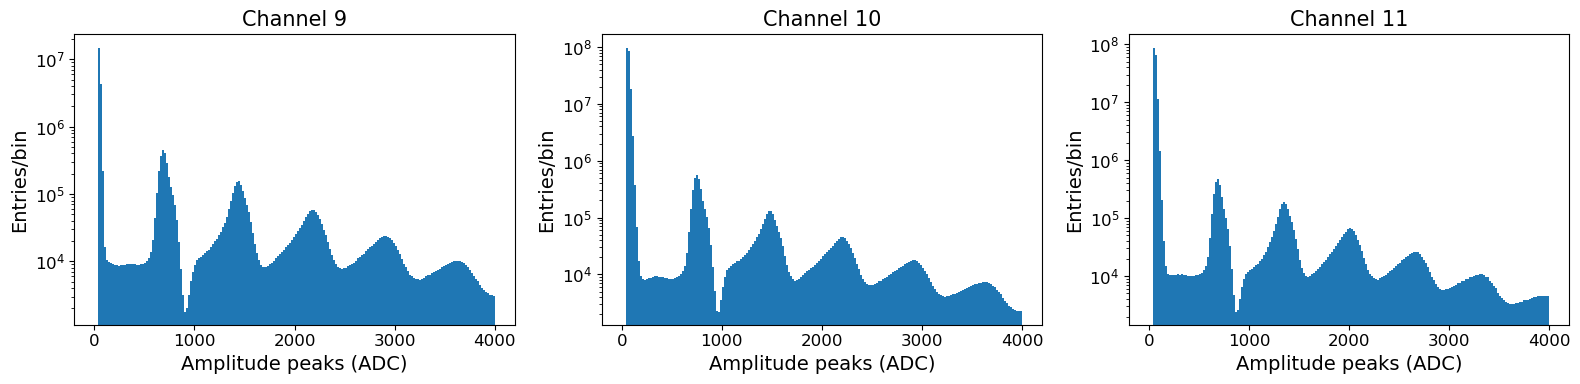

In [182]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k in [9, 10, 11]:
    j = k%3

    ch_vals = np.concatenate(([np.concatenate((h_peak_sg_d_trigg_all [date][k])) for date in idx_peak_thr_trigg_all.keys()]))
    
    axs[j].hist(ch_vals, 200, range=(0, 4000))
    axs[j].set_ylabel('Entries/bin',           fontsize=14)
    axs[j].set_xlabel('Amplitude peaks (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    axs[j].set_yscale('log')
plt.tight_layout()
plt.show()

## Reject events with light before the trigger time and light > 3000 ADC

In [10]:
idx_peak_thr_trigg_pretrigg_cut = {}
h_peak_sg_d_trigg_pretrigg_cut  = {}
num_evts_ch_trigg               = {}

print(len(filt_files))
for ifile,filename in enumerate(filt_files):
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    if date in ['09_10_2024']: #['09_08_2024', '09_09_2024']:
        
        if ifile%20==0:
            print(ifile)
            
        for ch in trigger_chs:
            idx_peaks_ch_after_cut    = []
            height_peaks_ch_after_cut = []
            num_evts                  = 0
            idx_peaks_ch    = d['idx_peaks_thr_ch_trigg_dict']         .item()[ch]
            height_peaks_ch = d['height_peaks_sg_deconv_ch_trigg_dict'].item()[ch]
            for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
                if len(idxs)==0:
                    continue
                noise_evts = (np.array(idxs)<650)&(np.array(vals)>300) ## Threshold for trigger channels
                if np.any(noise_evts):
                    continue
                if np.any(np.array(vals) > 3000):
                    continue
                else:
                    idx_peaks_ch_after_cut   .append(idxs)
                    height_peaks_ch_after_cut.append(vals)
                    num_evts += 1
                    
            if date not in idx_peak_thr_trigg_pretrigg_cut:
                idx_peak_thr_trigg_pretrigg_cut[date] = {}
                h_peak_sg_d_trigg_pretrigg_cut [date] = {}
                num_evts_ch_trigg              [date] = {}
        
            if ch not in idx_peak_thr_trigg_pretrigg_cut[date]:
                try:
                    idx_peak_thr_trigg_pretrigg_cut[date][ch] = np.concatenate(idx_peaks_ch_after_cut)
                    h_peak_sg_d_trigg_pretrigg_cut [date][ch] = np.concatenate(height_peaks_ch_after_cut)
                    num_evts_ch_trigg              [date][ch] = np.array([num_evts])
                except Exception as e:
                    print(e)
                    continue
            else:
                try:
                    idx_peak_thr_trigg_pretrigg_cut[date][ch] = np.concatenate((idx_peak_thr_trigg_pretrigg_cut[date][ch], np.concatenate(idx_peaks_ch_after_cut)))
                    h_peak_sg_d_trigg_pretrigg_cut [date][ch] = np.concatenate((h_peak_sg_d_trigg_pretrigg_cut [date][ch], np.concatenate(height_peaks_ch_after_cut)))
                    num_evts_ch_trigg              [date][ch] = np.concatenate((num_evts_ch_trigg              [date][ch], np.array([num_evts])))
                except Exception as e:
                    print(e)
                    continue

729


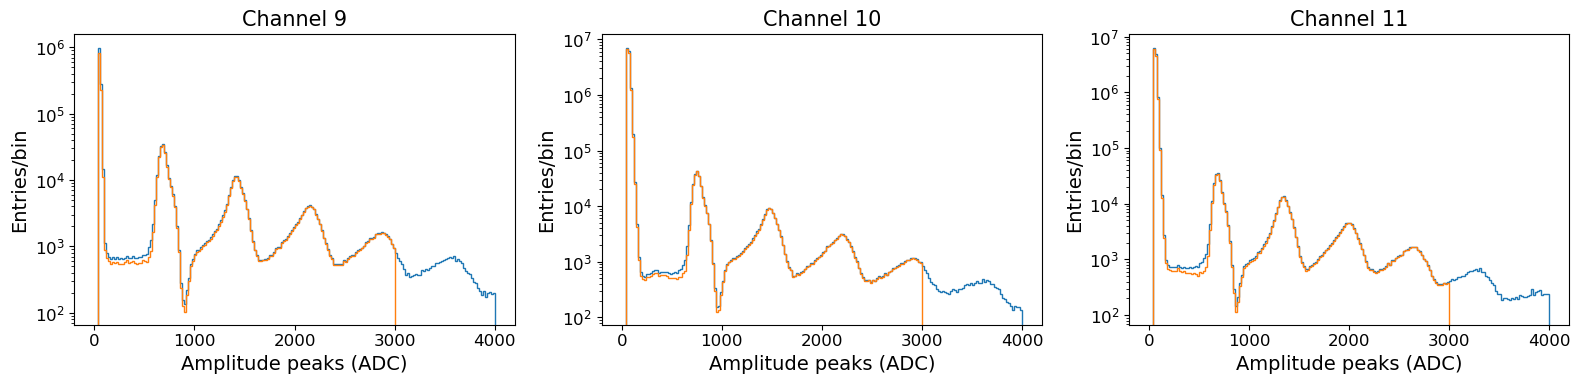

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k in [9, 10, 11]:
    j = k%3

    ch_vals0 = np.concatenate(([np.concatenate((h_peak_sg_d_trigg_all[date][k])) for date in idx_peak_thr_trigg_all.keys()]))
    ch_vals1 = np.concatenate([h_peak_sg_d_trigg_pretrigg_cut        [date][k]   for date in idx_peak_thr_trigg_all.keys()])
    
    axs[j].hist(ch_vals0, 200, range=(0, 4000), histtype='step')
    axs[j].hist(ch_vals1, 200, range=(0, 4000), histtype='step')
    axs[j].set_ylabel('Entries/bin',           fontsize=14)
    axs[j].set_xlabel('Amplitude peaks (ADC)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    axs[j].set_yscale('log')
plt.tight_layout()
plt.show()

## Fit peaks:

In [183]:
initial_guess_all_dates_ch = {9 : [320000, 690, 40, 10000, 1420, 60, 4000, 2140, 80, 1500, 2870, 100],
                              10: [320000, 750, 40, 10000, 1480, 60, 4000, 2200, 80, 1500, 2920, 100], 
                              11: [320000, 680, 40, 10000, 1340, 60, 4000, 2000, 80, 1500, 2640, 100]}

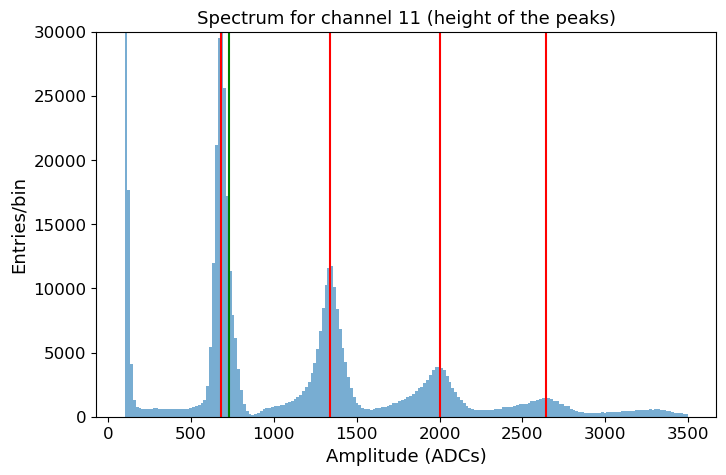

In [184]:
sel_channel = 11
sel_date    = '09_10_2024'
ch_vals     = np.concatenate((h_peak_sg_d_trigg_all[sel_date][sel_channel]))

plt.figure(figsize=(8, 5))
y, x, _ = plt.hist(ch_vals, bins=200, range=(100,3500), log=False, alpha=0.6)
plt.axvline(x=680, color='r')
plt.axvline(x=1340, color='r')
plt.axvline(x=2000, color='r')
plt.axvline(x=2640, color='r')
plt.axvline(x=730, color='g')
plt.xlabel('Amplitude (ADCs)',      fontsize=13)
plt.ylabel('Entries/bin',           fontsize=13)
plt.title(f"Spectrum for channel {sel_channel} (height of the peaks)", fontsize=13)
#plt.xlim(2500, 3500)
plt.ylim(0, 30000)
plt.show()

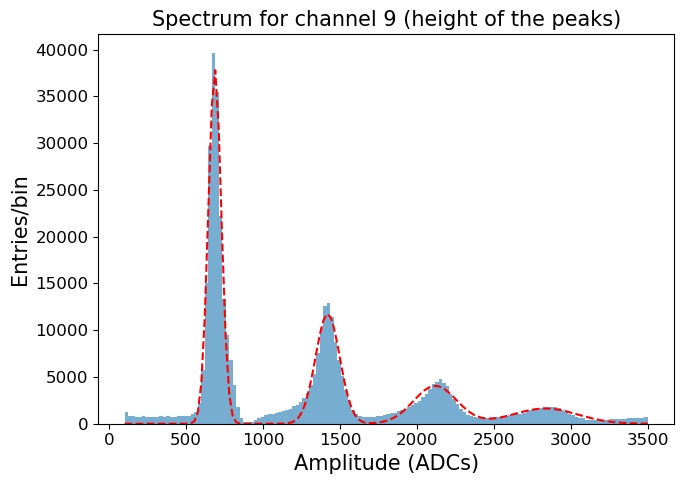

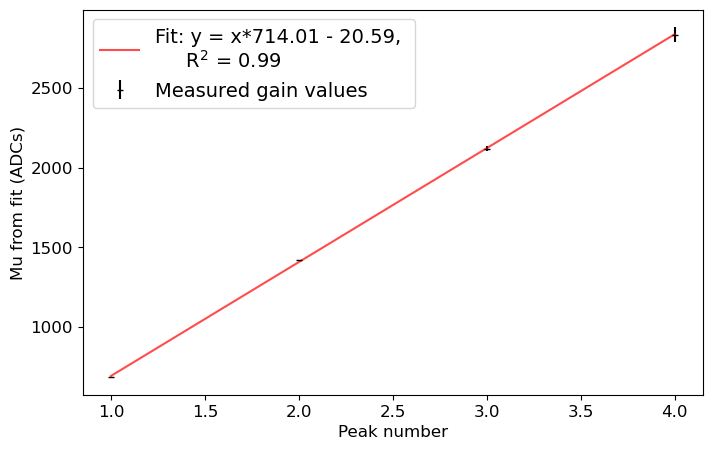

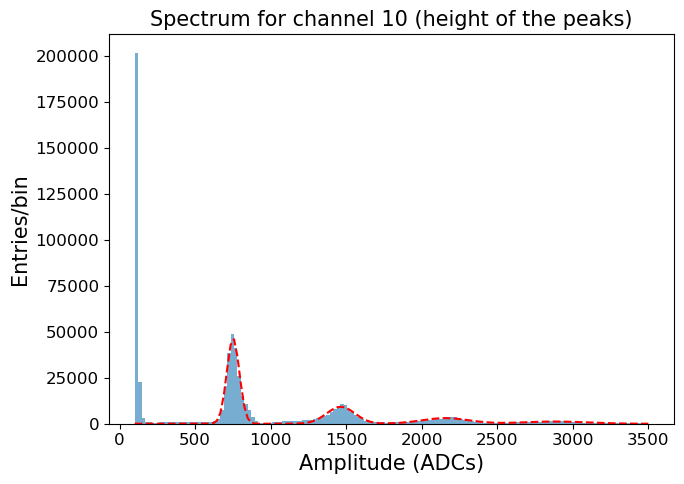

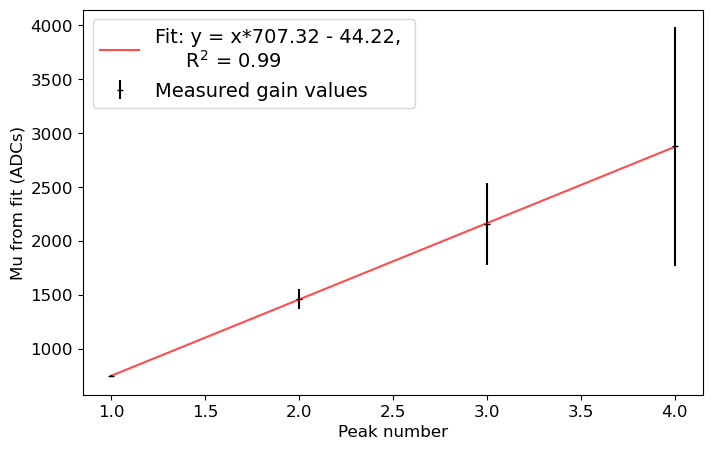

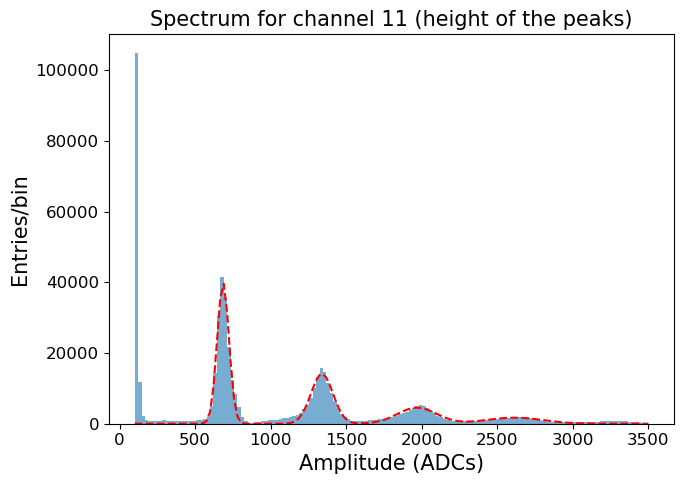

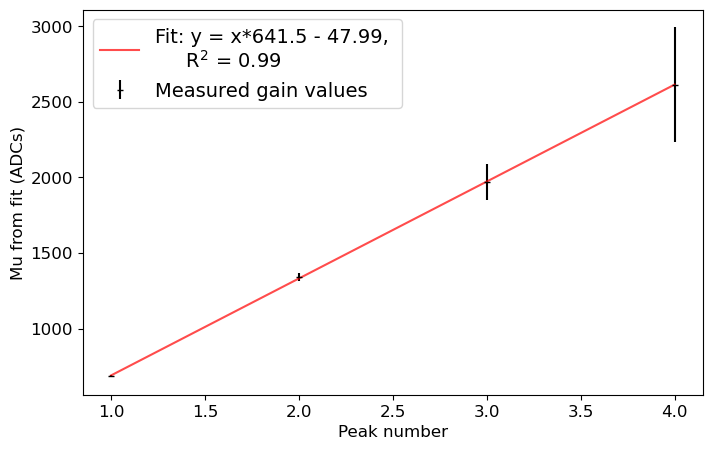

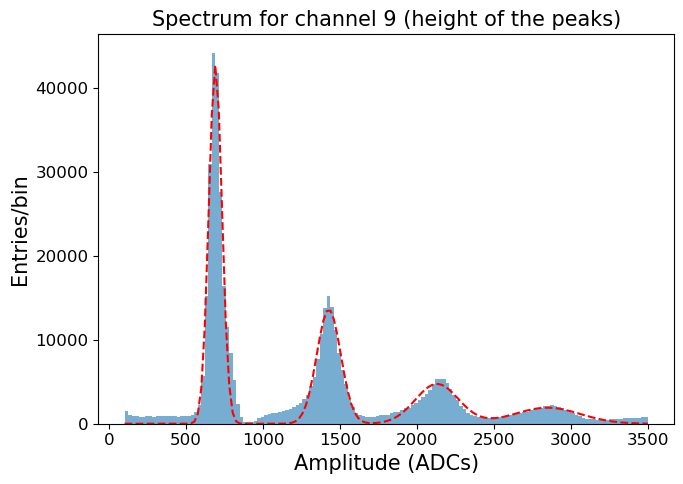

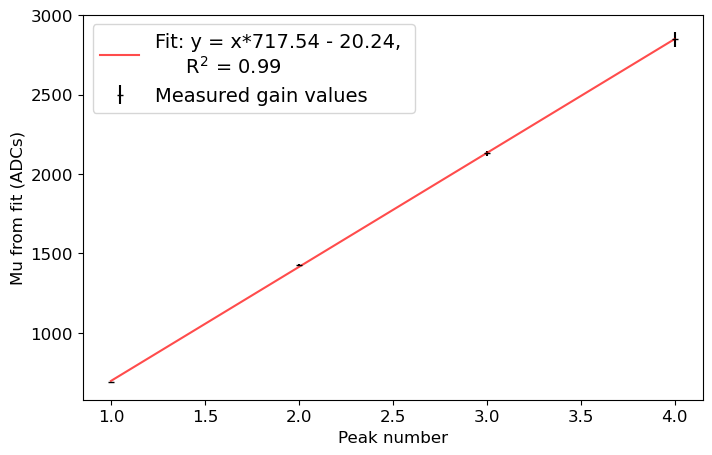

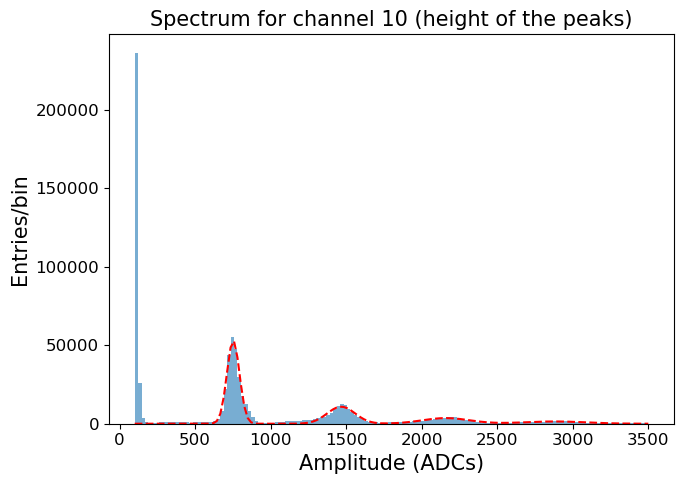

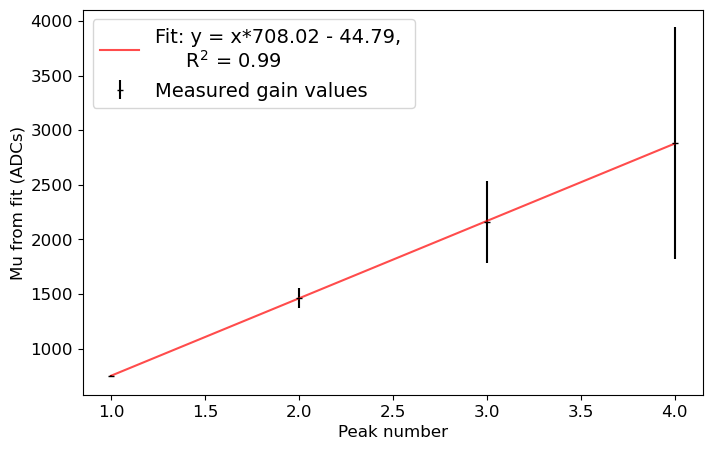

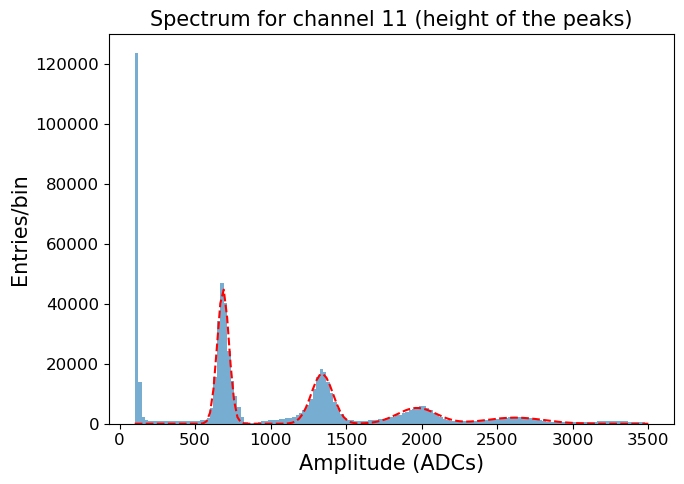

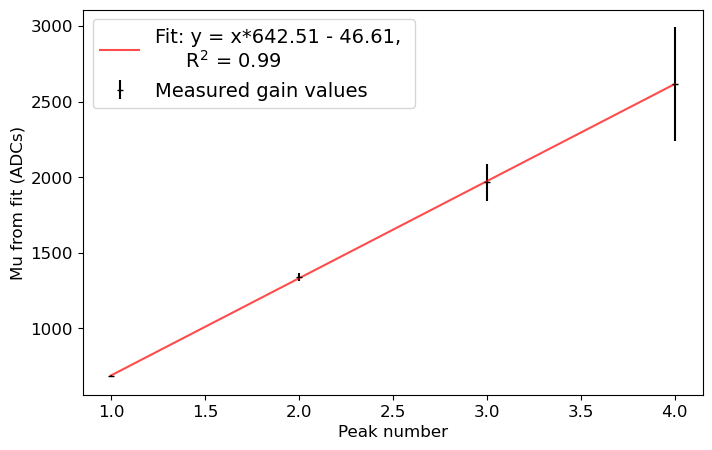

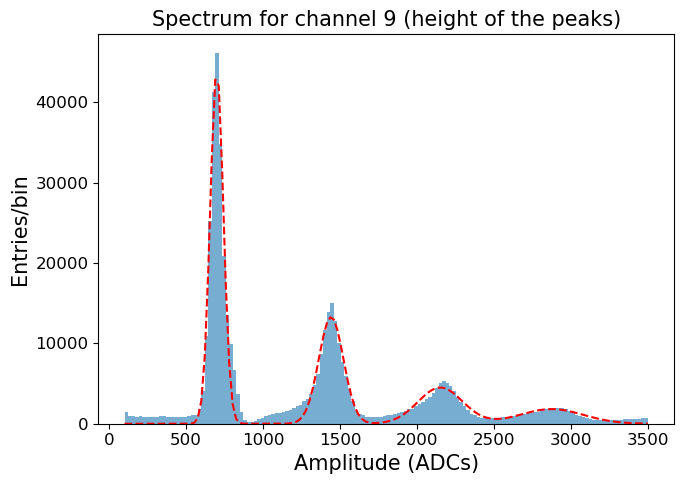

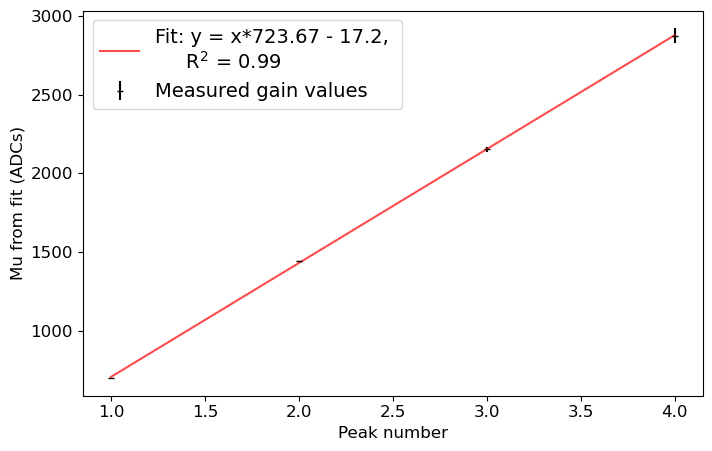

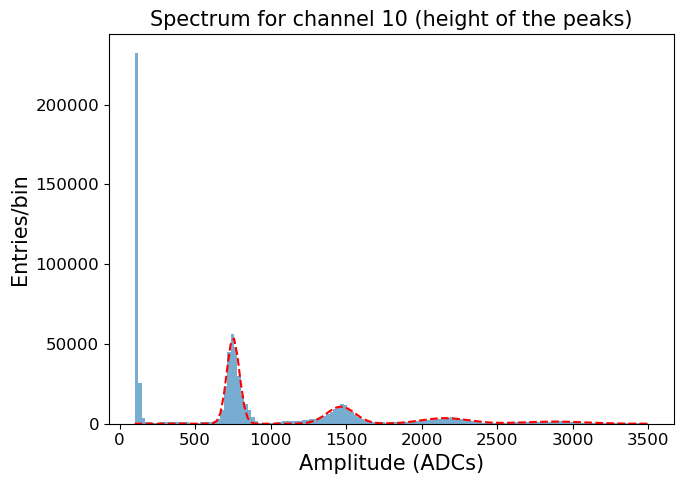

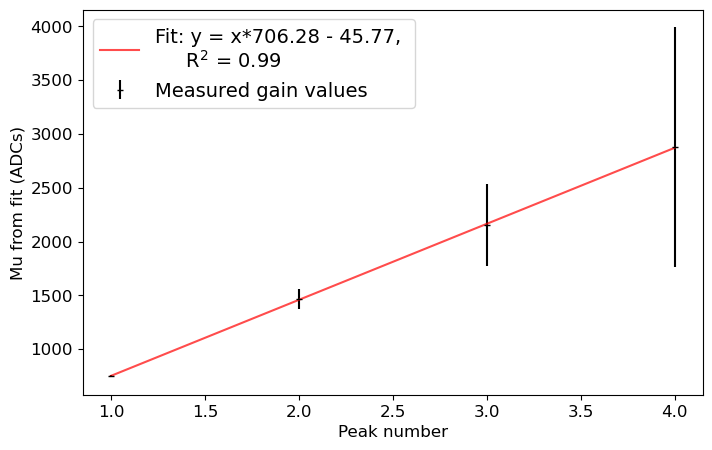

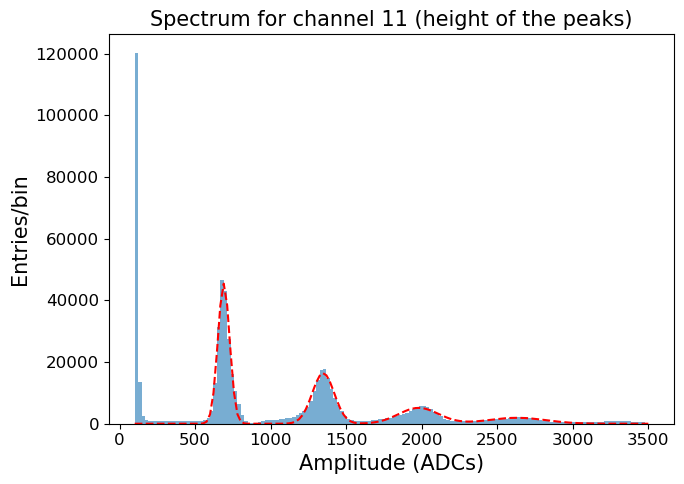

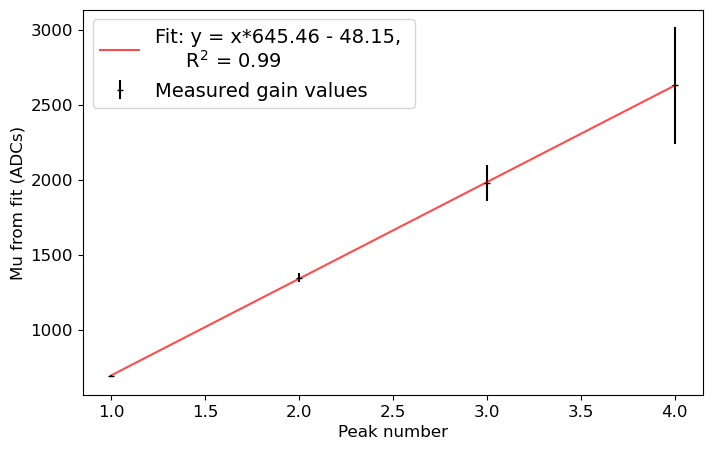

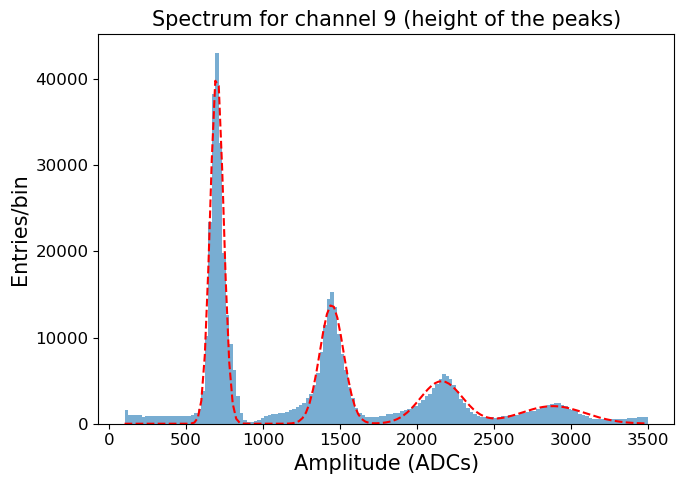

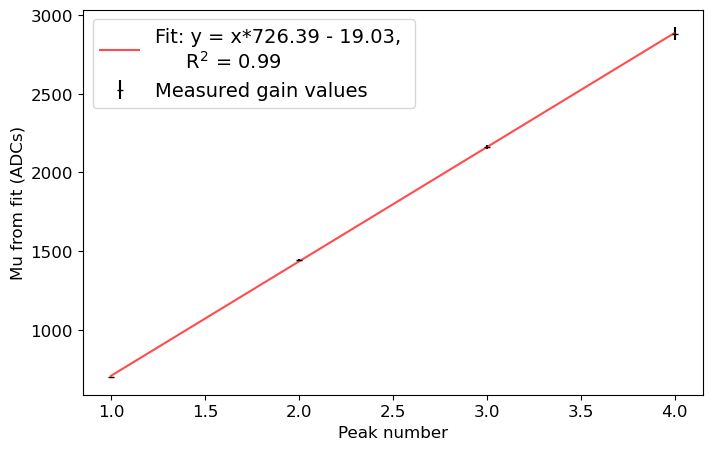

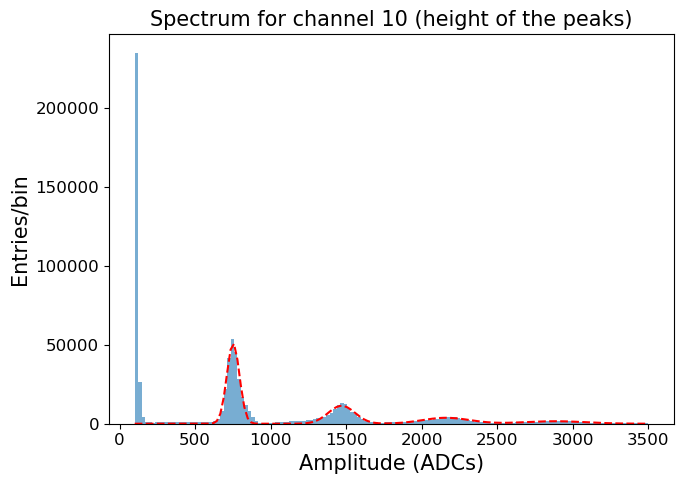

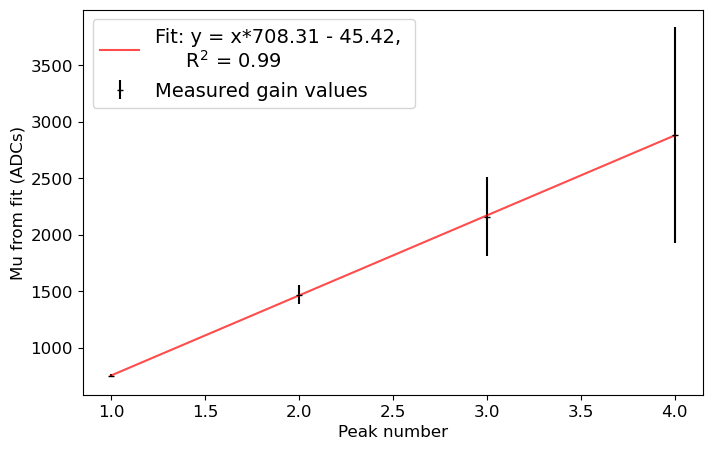

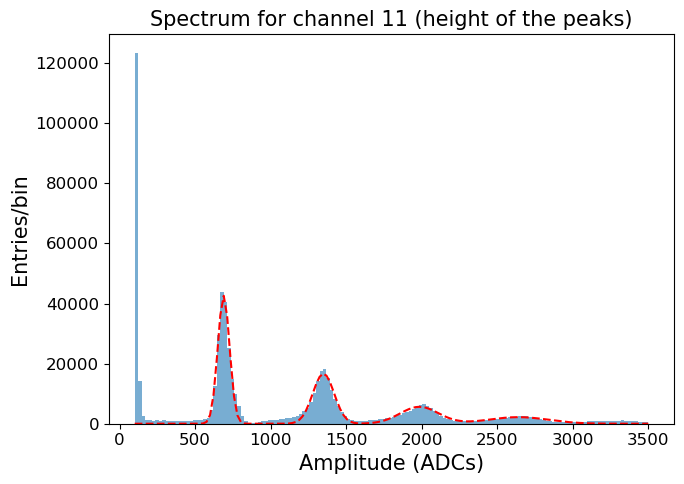

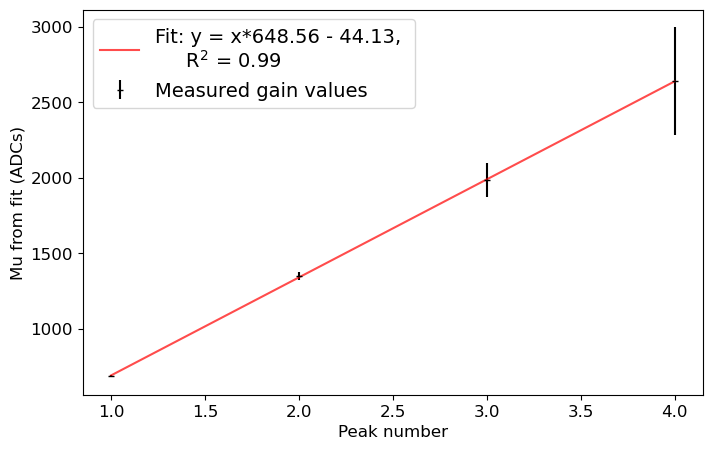

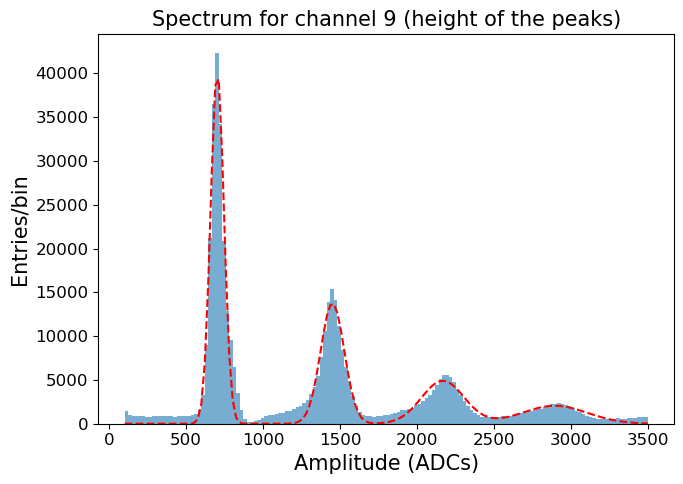

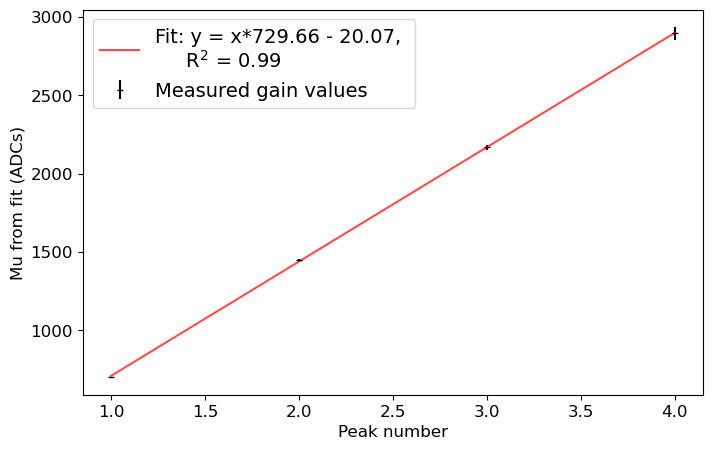

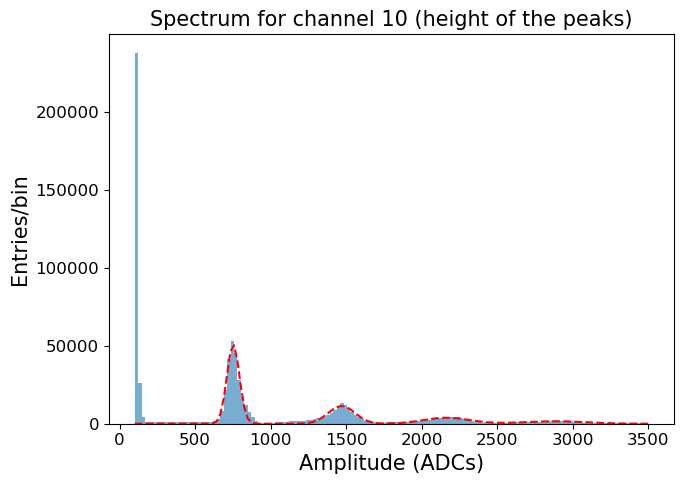

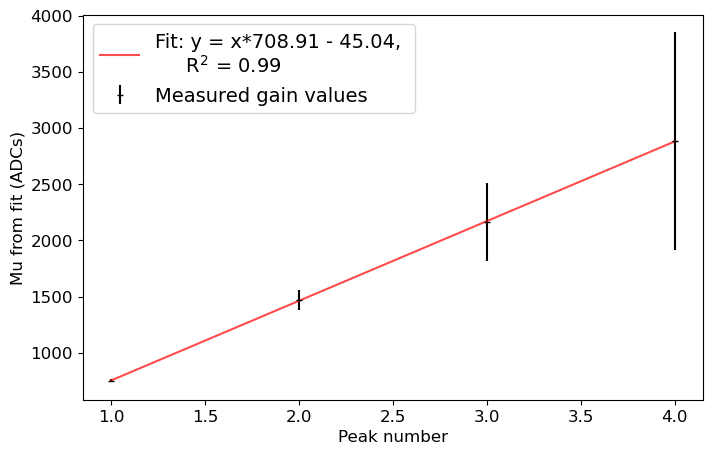

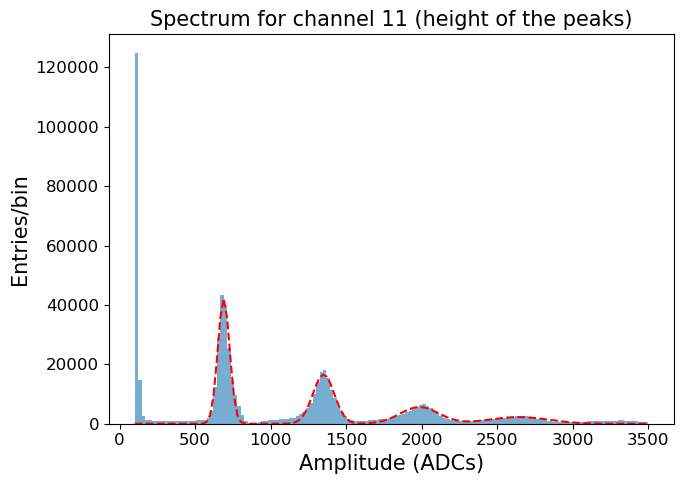

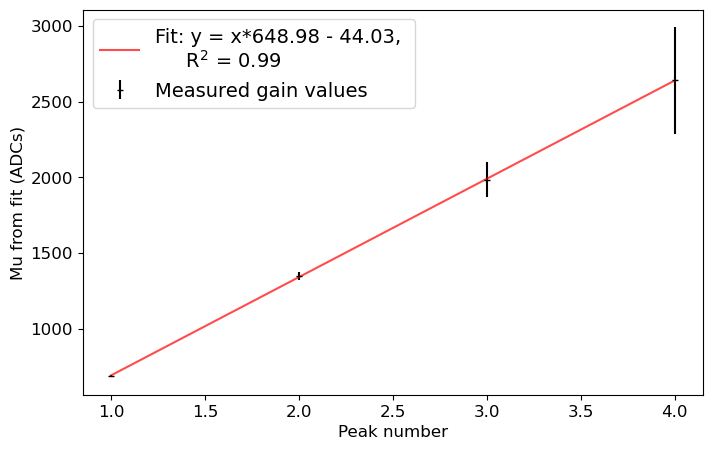

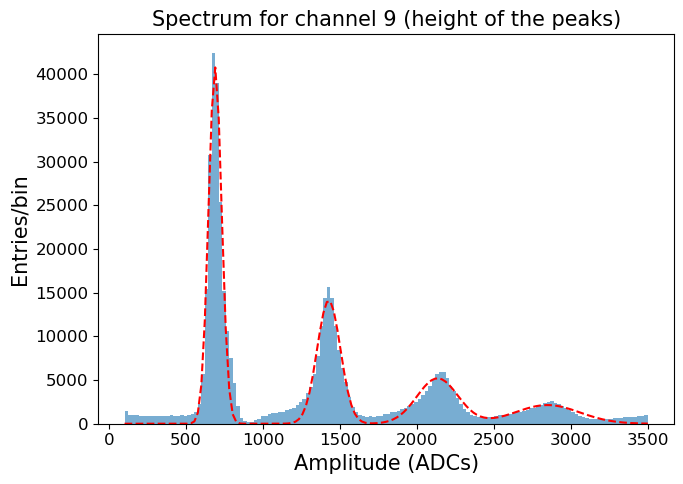

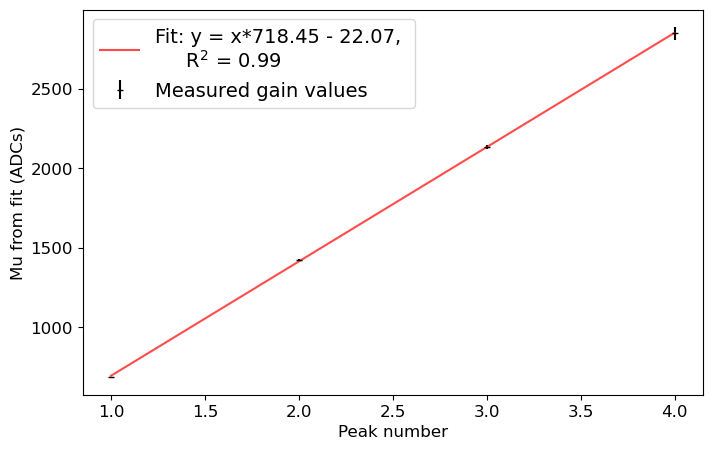

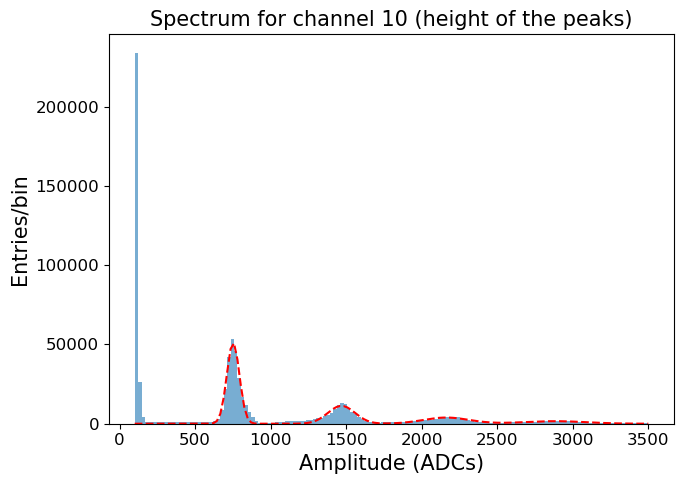

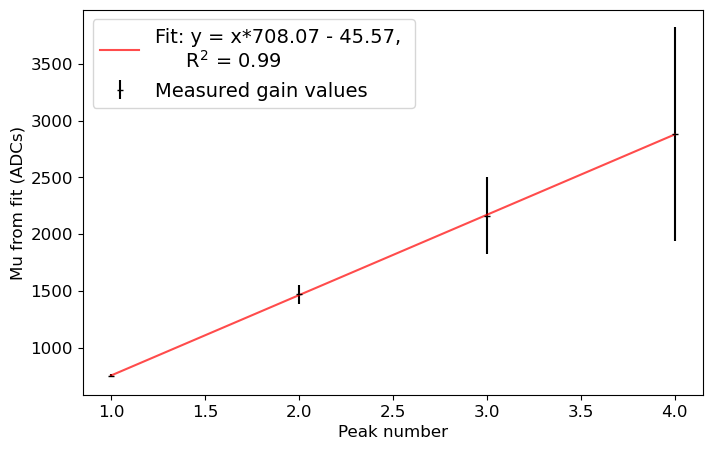

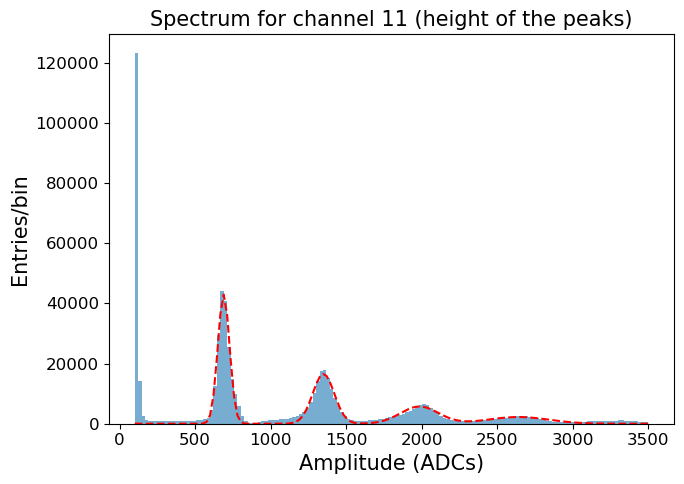

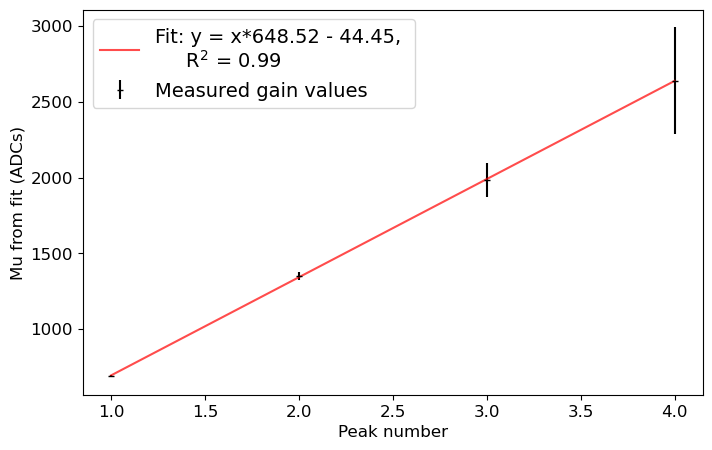

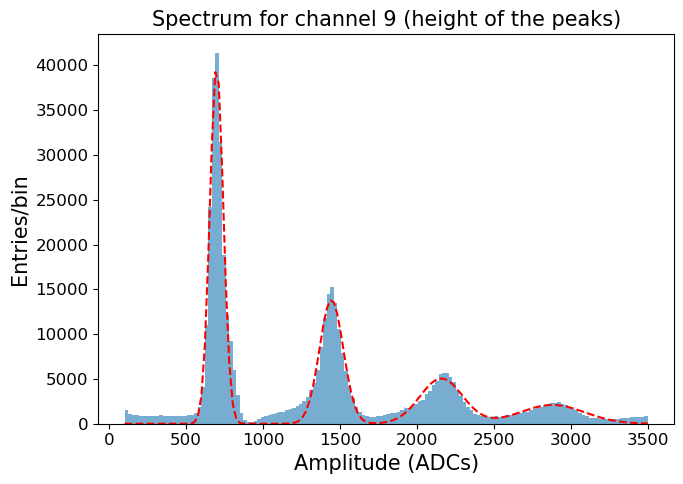

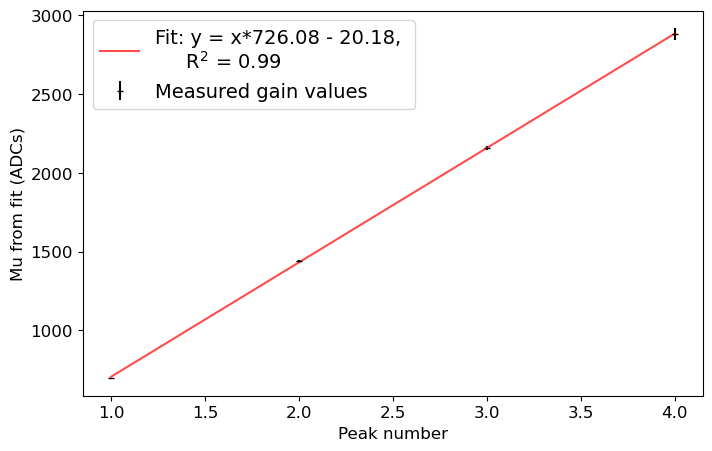

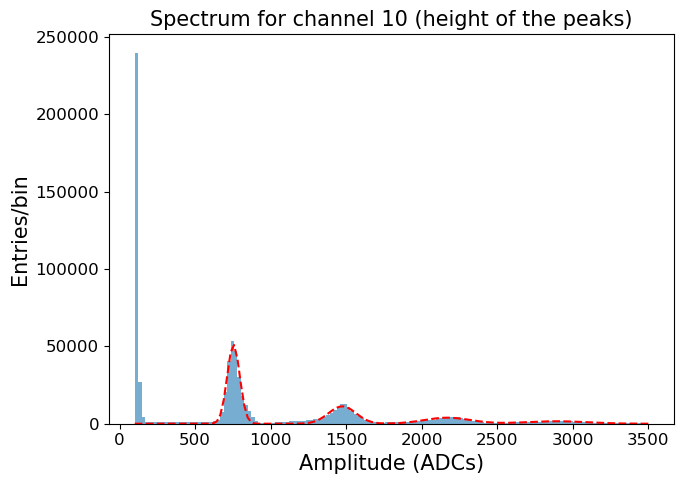

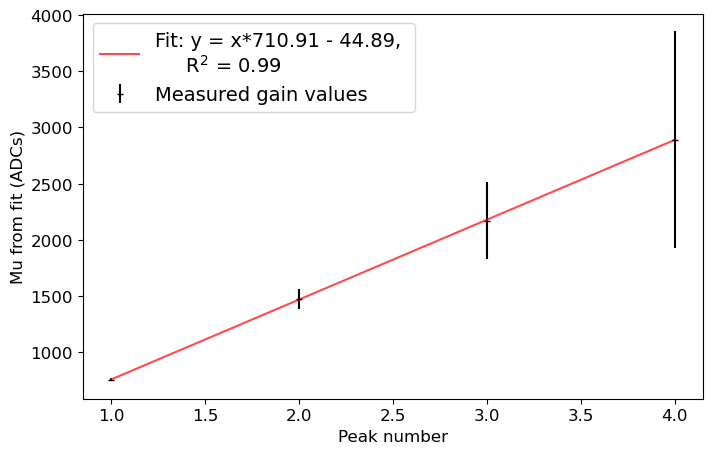

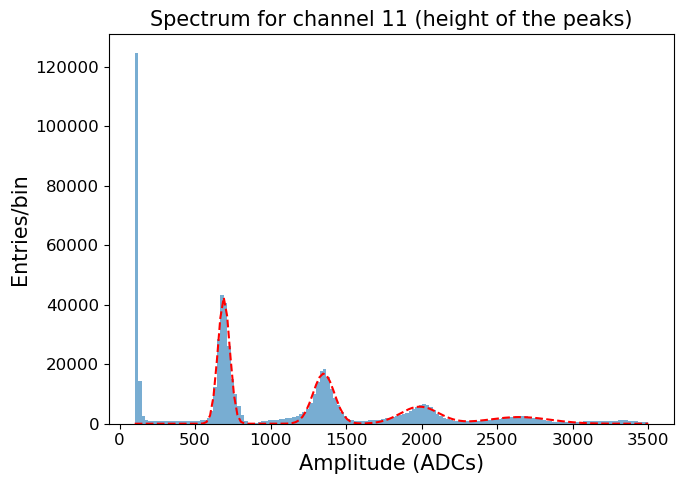

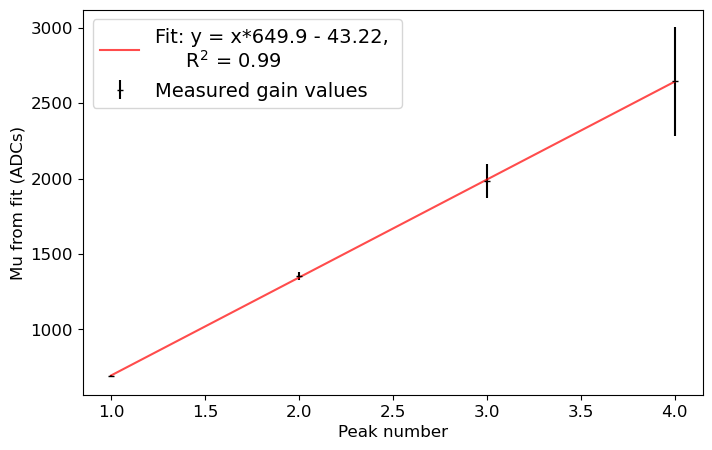

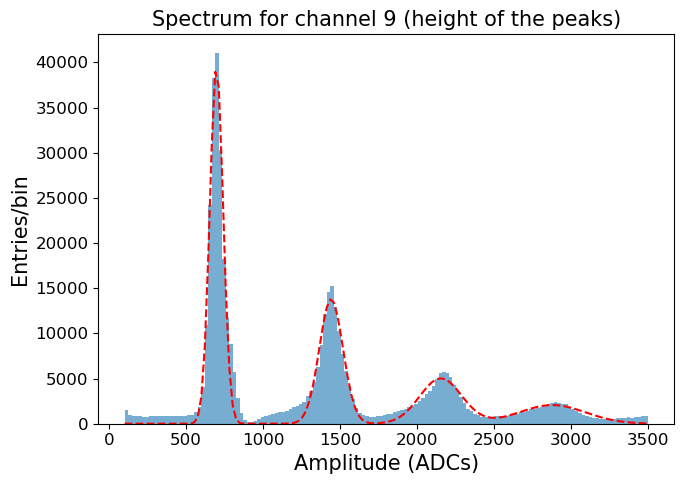

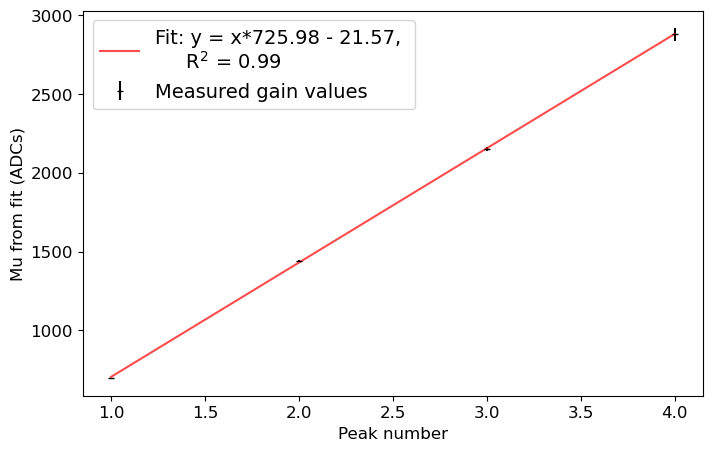

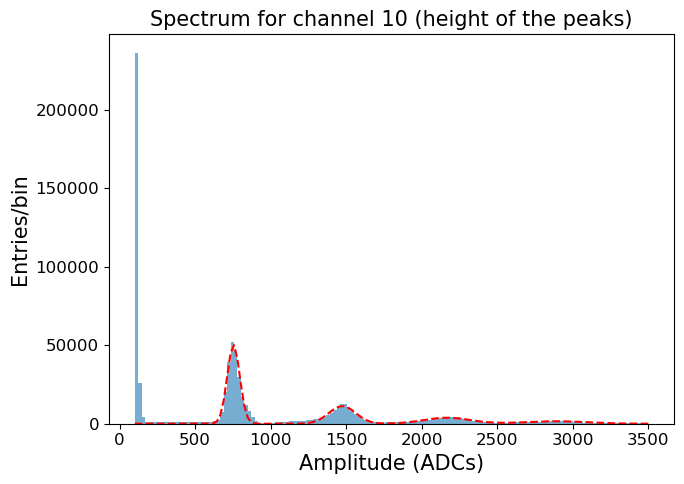

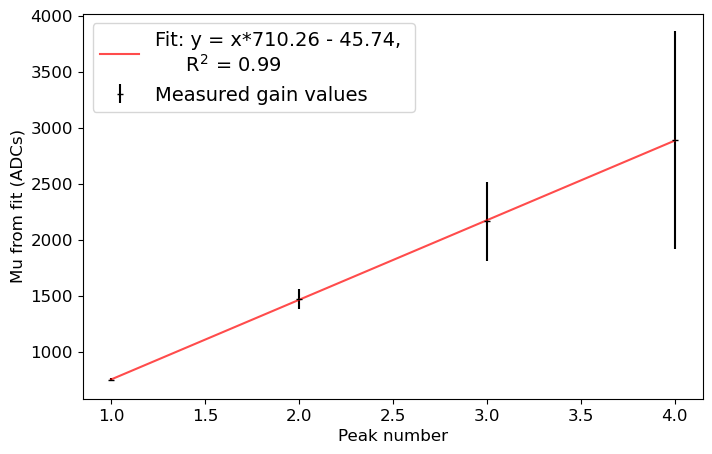

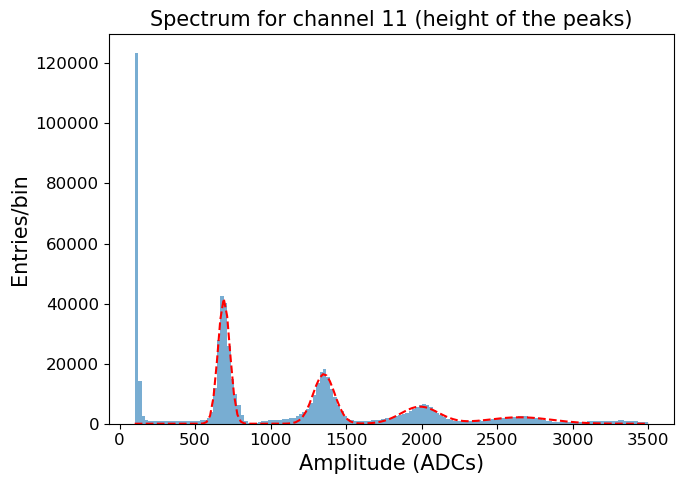

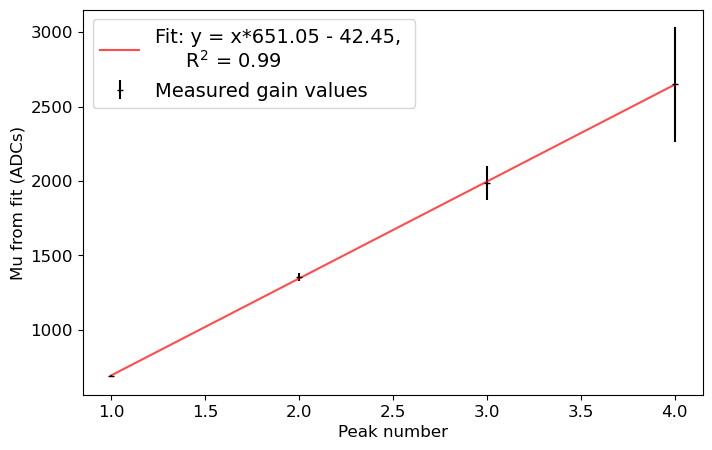

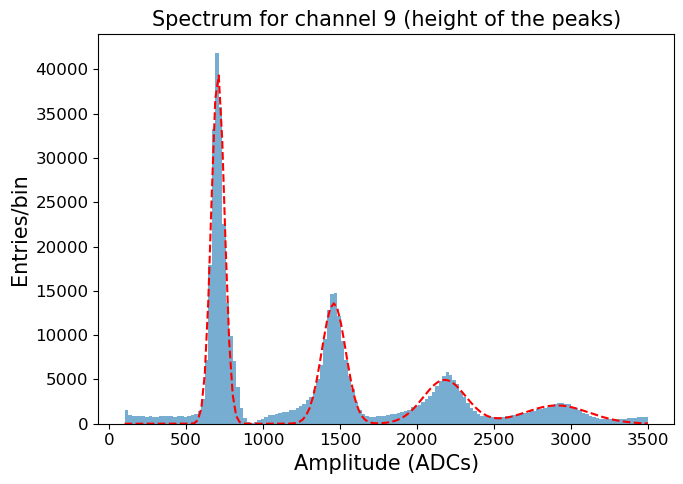

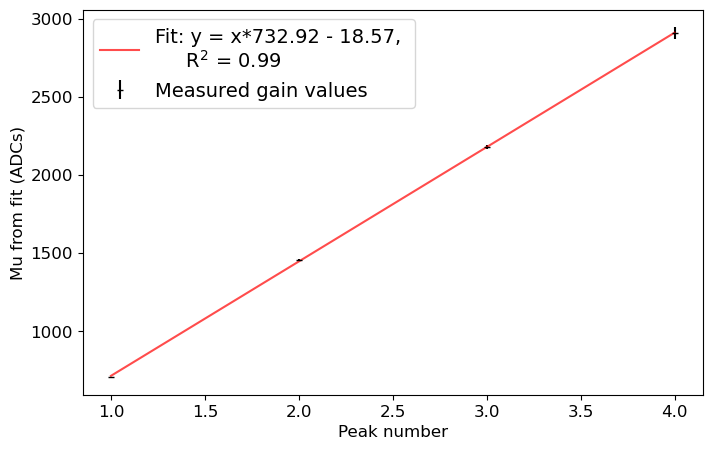

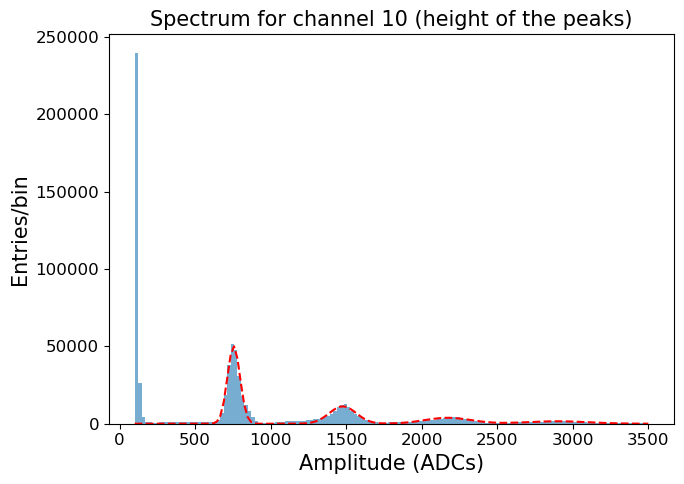

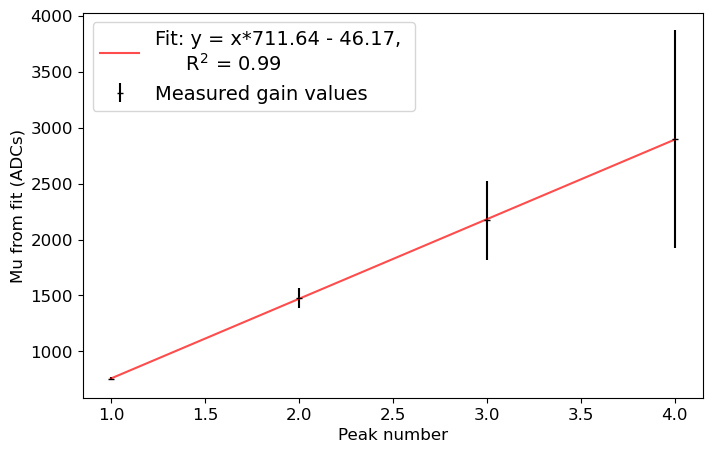

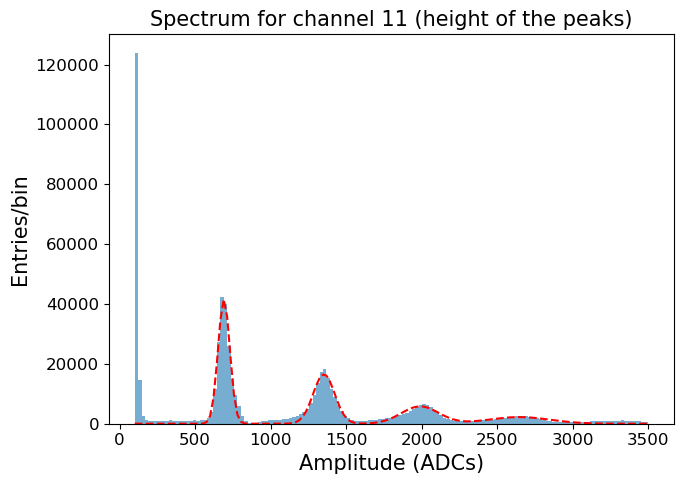

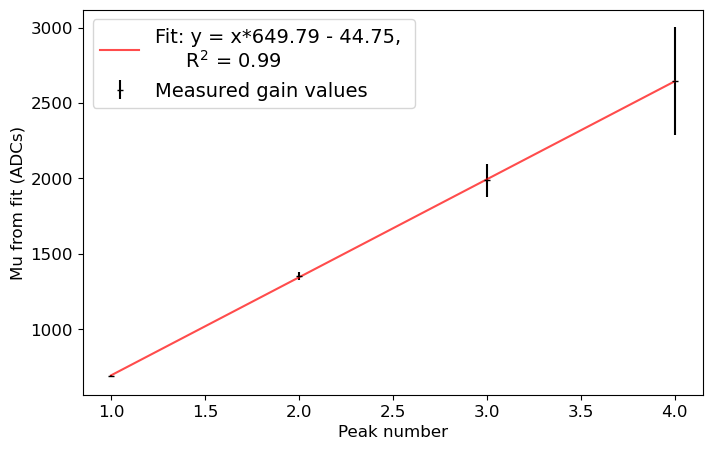

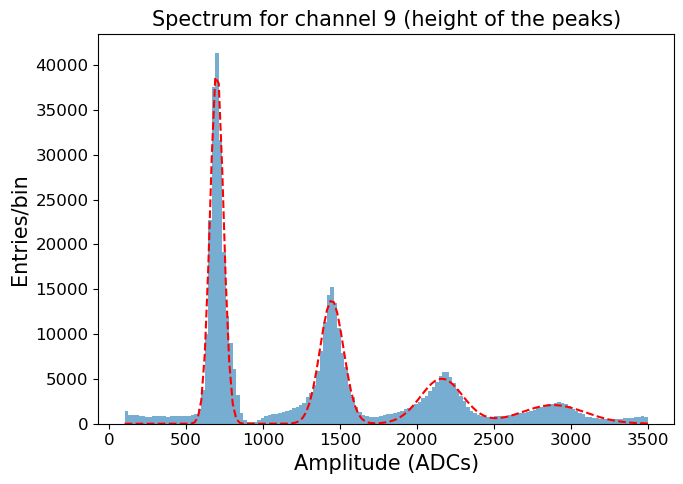

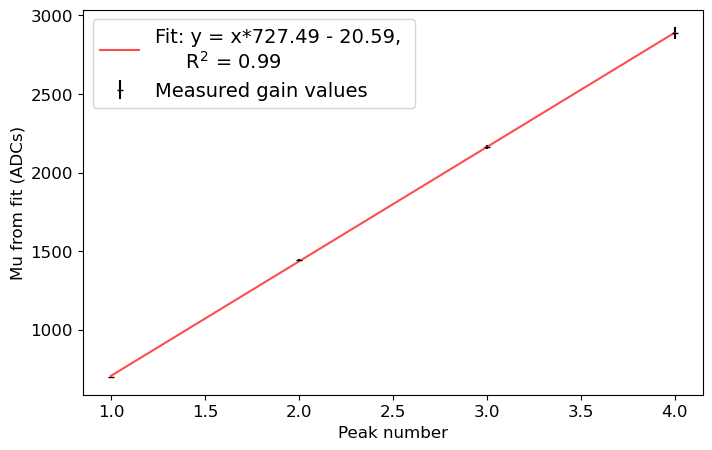

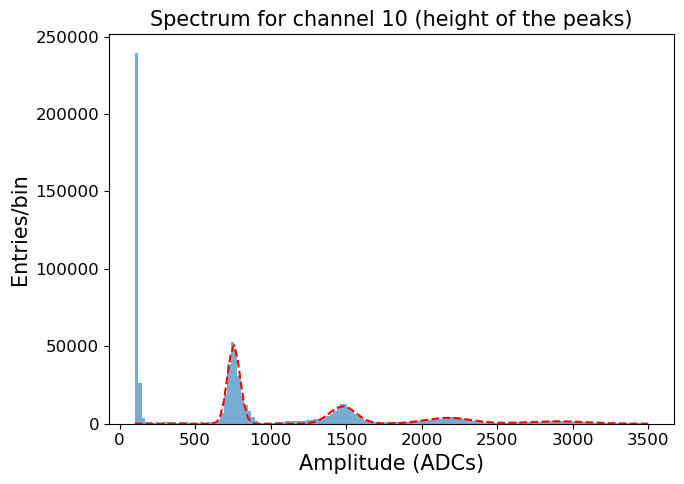

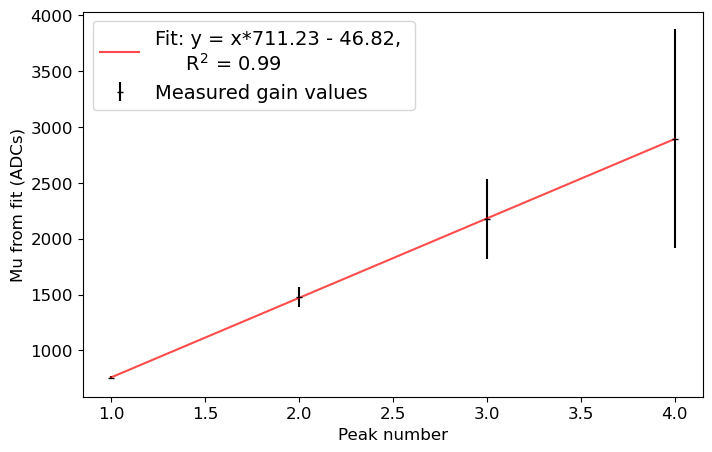

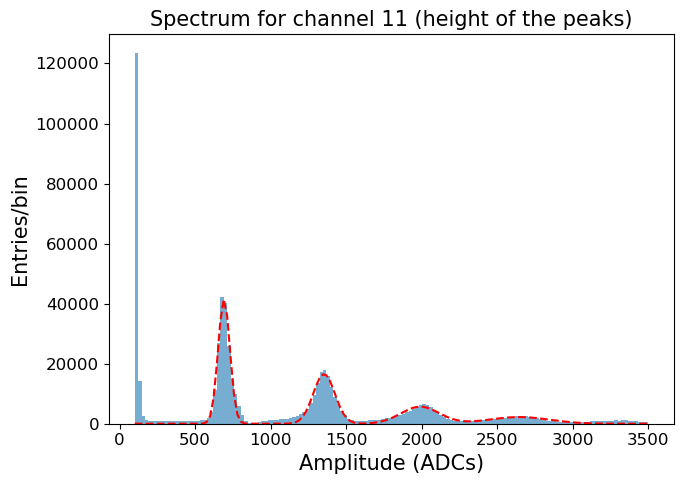

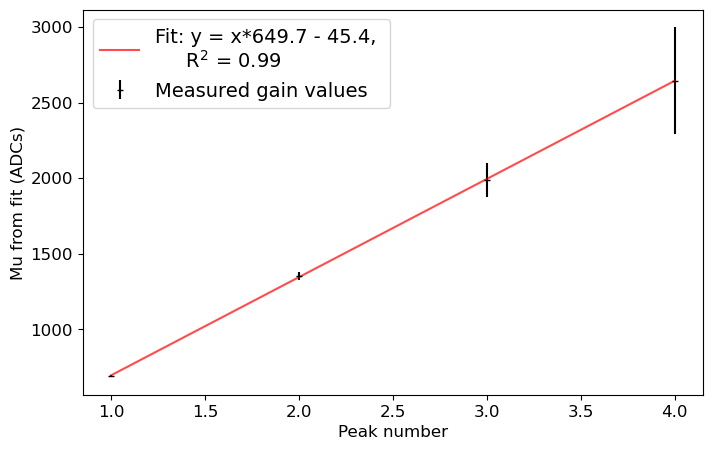

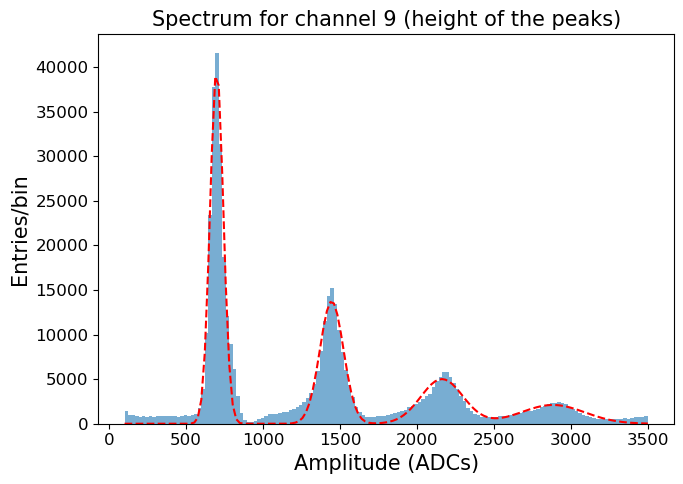

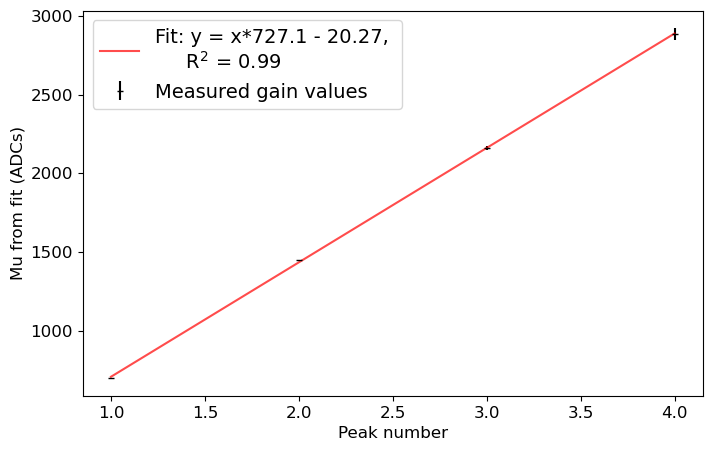

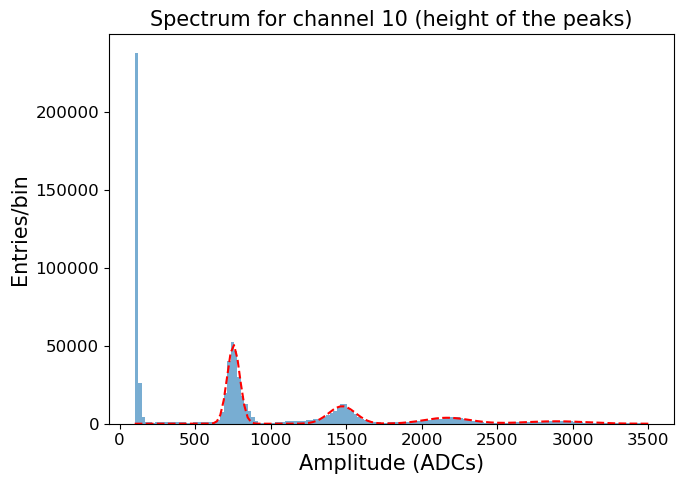

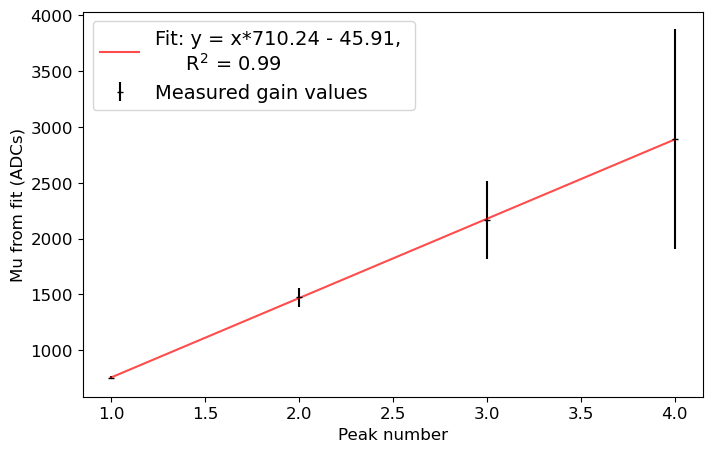

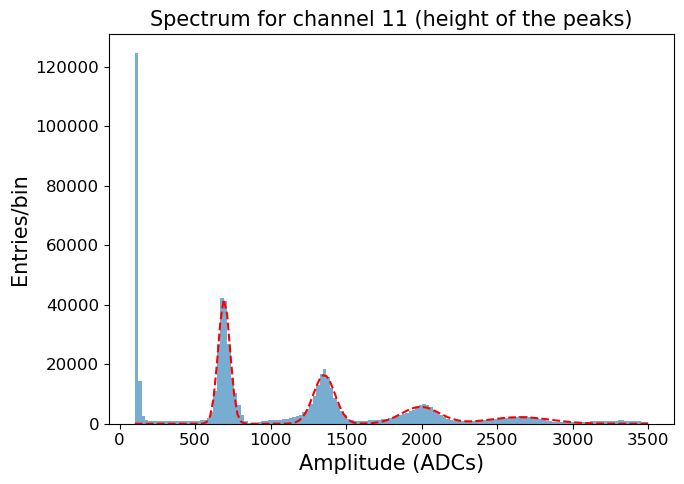

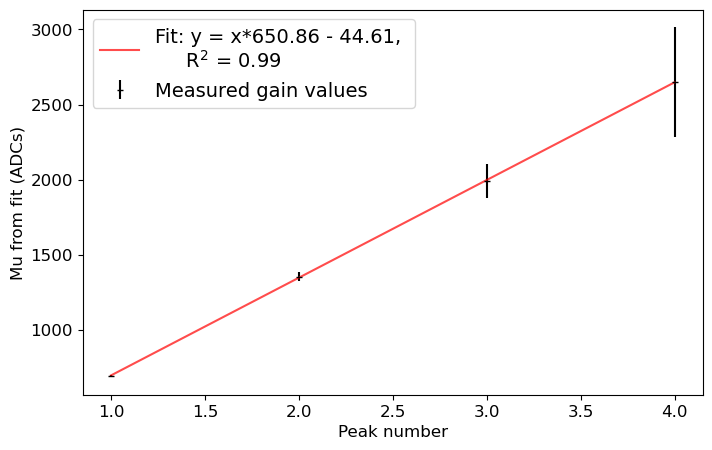

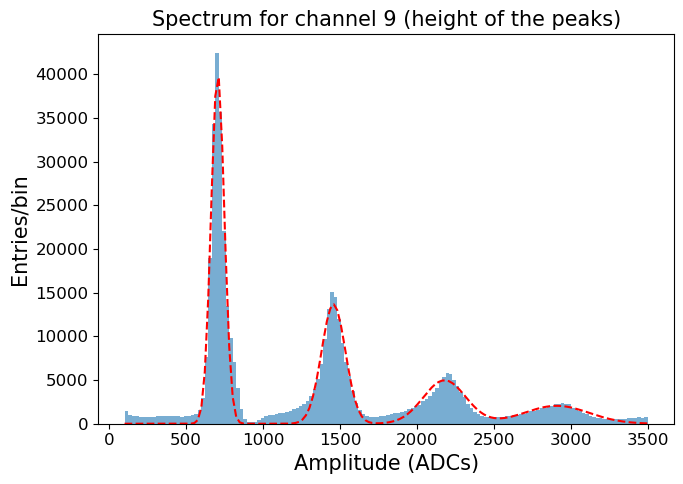

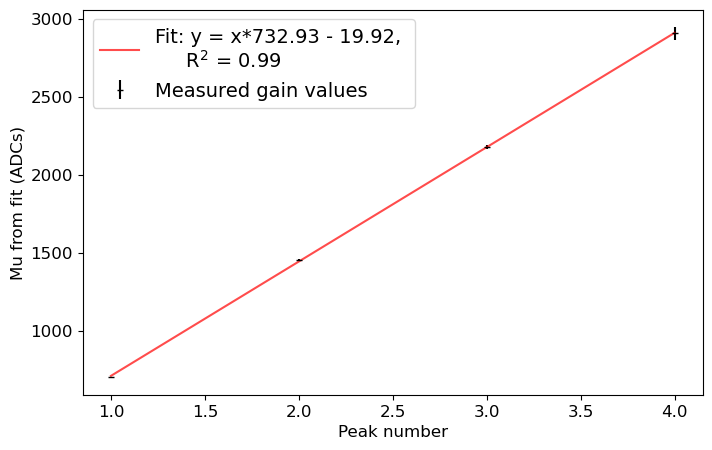

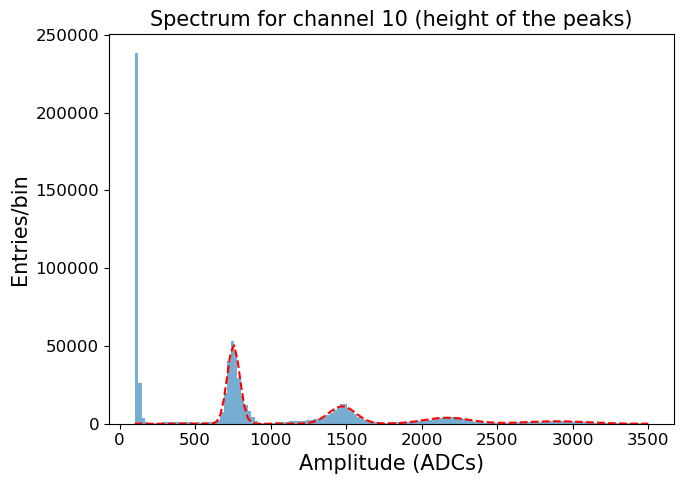

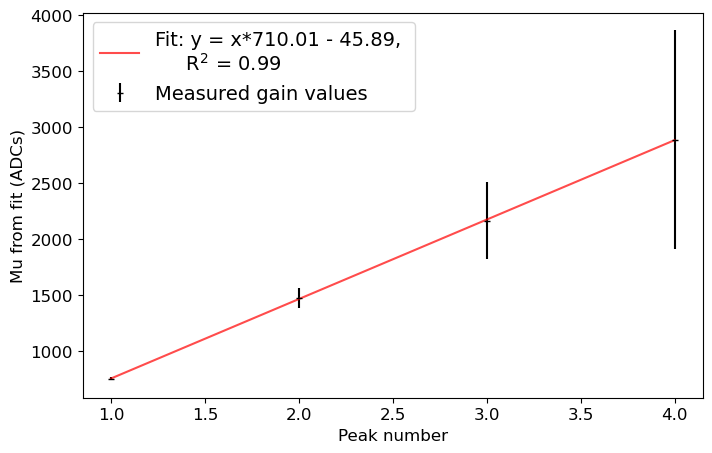

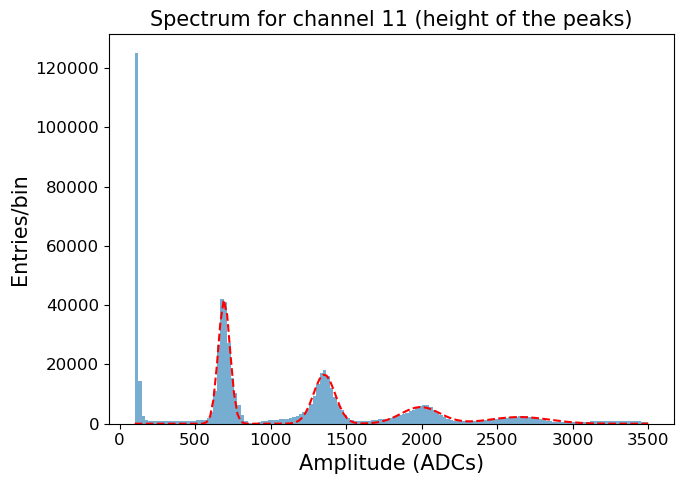

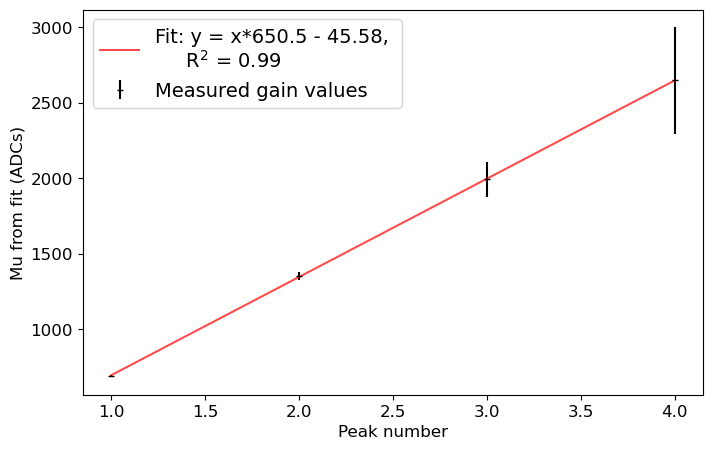

In [185]:
slopes = {}
for date in all_dates:
    slope_chs = {}
    for k in [9, 10, 11]:
        ch_vals = np.concatenate((h_peak_sg_d_trigg_all[date][k]))
        try:
            slope = fitf.fit_spectrum_and_plot(ch_vals, channel=k, initial_guess=initial_guess_all_dates_ch[k], rng=(100, 3500))
            slope_chs[k] = slope
        except RuntimeError:
            slope_chs[k] = 0
            continue
    slopes[date] = slope_chs

In [186]:
def change_date_format(date, symb='/'):
    els = date.split('_')
    return els[0] + symb + els[1] + symb + els[2] 

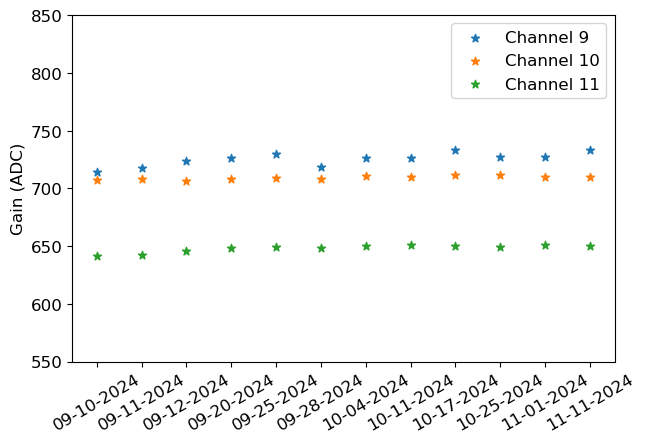

In [187]:
plt.figure(figsize=(7, 4.5))
for k in [9, 10, 11]:
    slopes_ch  = [slopes[date][k] for date in all_dates]
    all_dates2 = [change_date_format(date, '-') for date in all_dates]
    plt.scatter(all_dates2, slopes_ch, marker='*', label=f'Channel {k}')
    plt.tick_params(axis='x', rotation=30)
plt.ylim(550, 850)
plt.ylabel('Gain (ADC)')
plt.legend()
plt.show()

## Make spectrum with the 3 trigger channels:

In [188]:
h_peak_sg_d_trigg2_ch9  = {}
h_peak_sg_d_trigg2_ch10 = {}
h_peak_sg_d_trigg2_ch11 = {}

for date in all_dates:
    print(date)
    date_files20 = sorted(glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_w{sg_filt_window}_dist{min_dist}_run-{date}*'), key=extract_date_and_number)[:20]
    height_peaks_ch_after_cut_9  = []
    height_peaks_ch_after_cut_10 = []
    height_peaks_ch_after_cut_11 = []
    num_evts                     = 0
    for ifile,filename in enumerate(date_files20):
        d = np.load(filename, allow_pickle=True)
        idx_peaks_ch9     = d['idx_peaks_thr_ch_trigg_dict']         .item()[9]
        height_peaks_ch9  = d['height_peaks_sg_deconv_ch_trigg_dict'].item()[9]
        idx_peaks_ch10    = d['idx_peaks_thr_ch_trigg_dict']         .item()[10]
        height_peaks_ch10 = d['height_peaks_sg_deconv_ch_trigg_dict'].item()[10]
        idx_peaks_ch11    = d['idx_peaks_thr_ch_trigg_dict']         .item()[11]
        height_peaks_ch11 = d['height_peaks_sg_deconv_ch_trigg_dict'].item()[11]
        for idxs9, vals9, idxs10, vals10, idxs11, vals11 in zip(idx_peaks_ch9, height_peaks_ch9, idx_peaks_ch10, height_peaks_ch10, idx_peaks_ch11, height_peaks_ch11):
            if len(idxs9)==0 or len(idxs10)==0 or len(idxs11)==0:
                continue
            noise_evts9  = (np.array(idxs9) <650)&(np.array(vals9) >300) ## Threshold for trigger channels
            noise_evts10 = (np.array(idxs10)<650)&(np.array(vals10)>300) ## Threshold for trigger channels
            noise_evts11 = (np.array(idxs11)<650)&(np.array(vals11)>300) ## Threshold for trigger channels
            if np.any(noise_evts9) or np.any(noise_evts10) or np.any(noise_evts11):
                continue
            else:
                height_peaks_ch_after_cut_9 .append(np.sum(vals9 /slopes[date][9]))
                height_peaks_ch_after_cut_10.append(np.sum(vals10/slopes[date][10]))
                height_peaks_ch_after_cut_11.append(np.sum(vals11/slopes[date][11]))
                num_evts += 1
    
        h_peak_sg_d_trigg2_ch9 [date] = height_peaks_ch_after_cut_9
        h_peak_sg_d_trigg2_ch10[date] = height_peaks_ch_after_cut_10
        h_peak_sg_d_trigg2_ch11[date] = height_peaks_ch_after_cut_11

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024


In [126]:
h_peak_sg_d_trigg2_ch9_test  = {}

for date in all_dates:
    print(date)
    date_files20 = sorted(glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_w{sg_filt_window}_dist{min_dist}_run-{date}*'), key=extract_date_and_number)[:20]
    height_peaks_ch_after_cut_9  = []
    for ifile,filename in enumerate(date_files20):
        d = np.load(filename, allow_pickle=True)
        idx_peaks_ch9     = d['idx_peaks_thr_ch_trigg_dict']         .item()[9]
        height_peaks_ch9  = d['height_peaks_sg_deconv_ch_trigg_dict'].item()[9]
        for idxs9, vals9 in zip(idx_peaks_ch9, height_peaks_ch9):
            if len(idxs9)==0 or len(idxs10)==0 or len(idxs11)==0:
                continue
            noise_evts9  = (np.array(idxs9) <650)&(np.array(vals9) >300) ## Threshold for trigger channels
            if np.any(noise_evts9):
                continue
            else:
                height_peaks_ch_after_cut_9.append(np.sum(vals9))
    
        h_peak_sg_d_trigg2_ch9_test[date] = height_peaks_ch_after_cut_9

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024


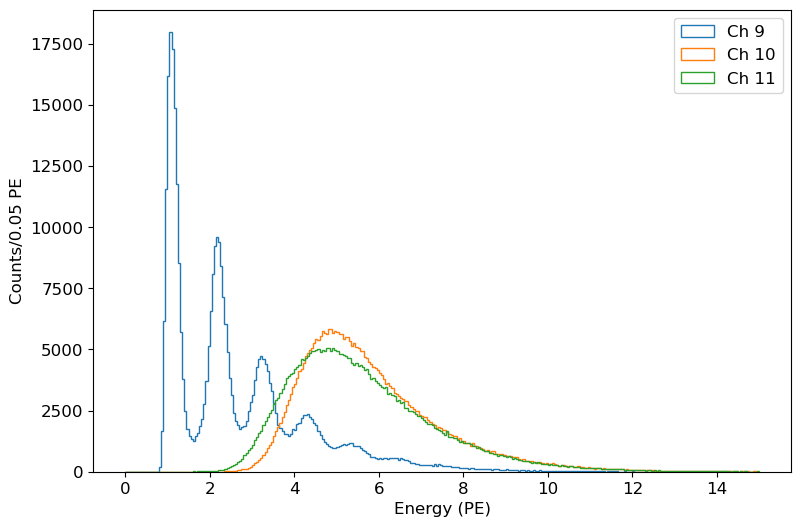

In [189]:
plt.hist(h_peak_sg_d_trigg2_ch9 ['09_10_2024'], 300, range=(0, 15), histtype='step', label='Ch 9')
plt.hist(h_peak_sg_d_trigg2_ch10['09_10_2024'], 300, range=(0, 15), histtype='step', label='Ch 10')
plt.hist(h_peak_sg_d_trigg2_ch11['09_10_2024'], 300, range=(0, 15), histtype='step', label='Ch 11')
plt.xlabel('Energy (PE)')
plt.ylabel('Counts/0.05 PE')
plt.legend()
plt.show()

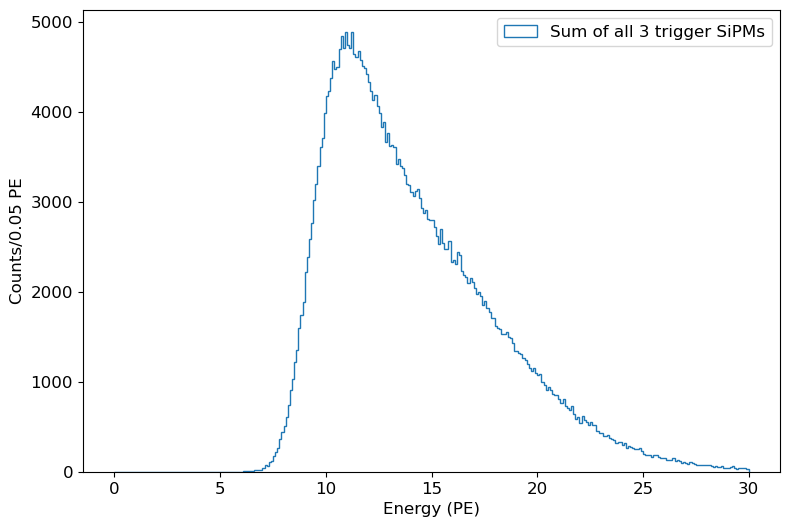

In [190]:
#plt.hist(np.concatenate((h_peak_sg_d_trigg2_ch9 ['09_10_2024'], h_peak_sg_d_trigg2_ch10['09_10_2024'], h_peak_sg_d_trigg2_ch11['09_10_2024'])), 300, range=(0, 15), histtype='step', label='All 3 trigger SiPMs')
plt.hist(np.sum([h_peak_sg_d_trigg2_ch9 ['09_10_2024'], h_peak_sg_d_trigg2_ch10['09_10_2024'], h_peak_sg_d_trigg2_ch11['09_10_2024']], axis=0), 300, range=(0, 30), histtype='step', label='Sum of all 3 trigger SiPMs')
plt.xlabel('Energy (PE)')
plt.ylabel('Counts/0.05 PE')
plt.legend()
plt.show()

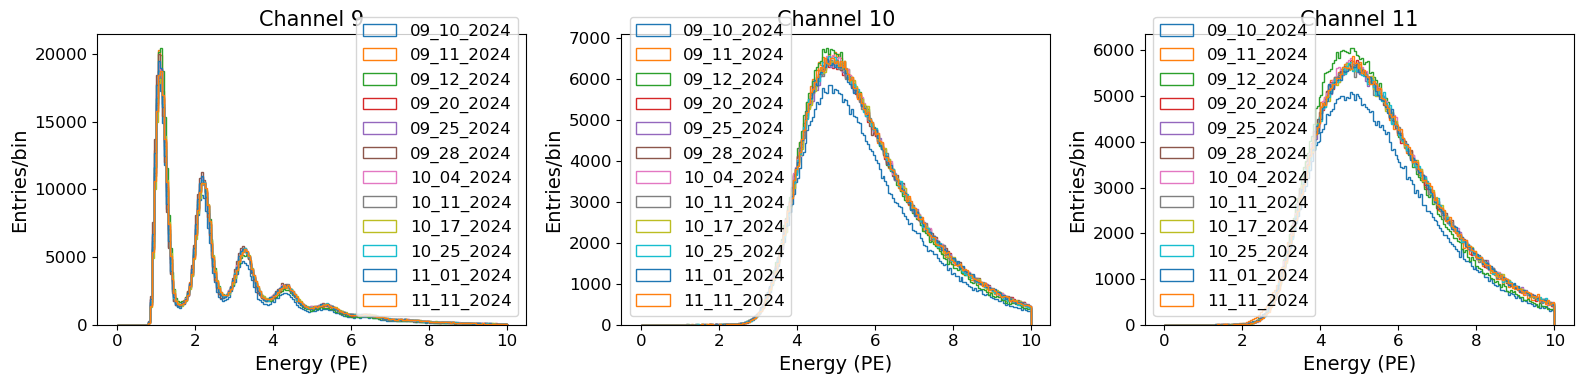

In [191]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for k, vals_ch in zip([9, 10, 11], [h_peak_sg_d_trigg2_ch9, h_peak_sg_d_trigg2_ch10, h_peak_sg_d_trigg2_ch11]):
    j = k%3

    for date in all_dates:
        axs[j].hist(vals_ch[date], 200, range=(0, 10), histtype='step', label=date)
    axs[j].set_ylabel('Entries/bin',           fontsize=14)
    axs[j].set_xlabel('Energy (PE)', fontsize=14)
    axs[j].set_title(f"Channel {k}",           fontsize=15)
    axs[j].legend()
plt.tight_layout()
plt.show()

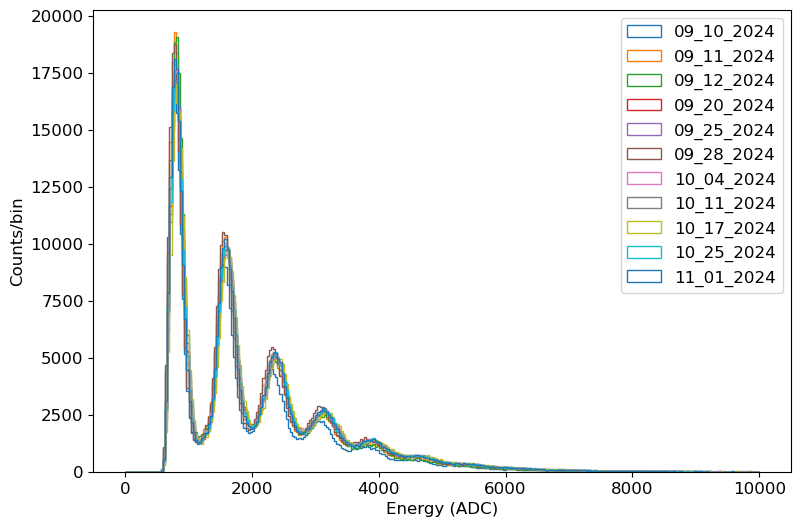

In [193]:
for date in all_dates:
    try:
        plt.hist(h_peak_sg_d_trigg2_ch9_test[date], 300, range=(0, 10000), histtype='step', label=date)
    except KeyError:
        continue
plt.xlabel('Energy (ADC)')
plt.ylabel('Counts/bin')
plt.legend()
plt.show()

## Compute gain using these data

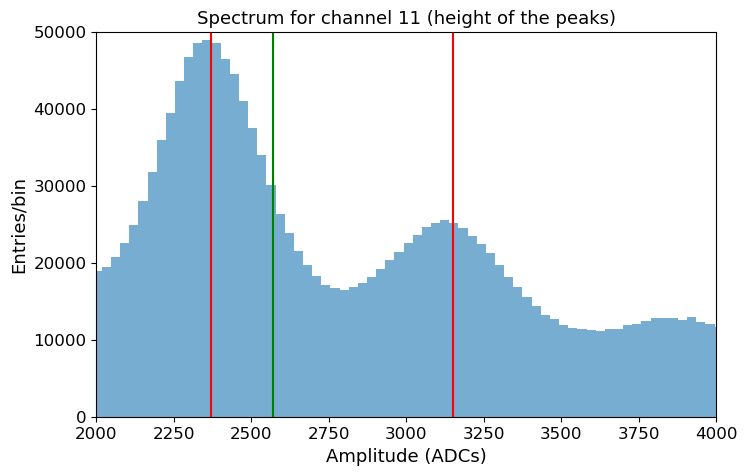

In [153]:
ch_vals = np.concatenate(([h_peak_sg_d_trigg2_ch9_test[date] for date in all_dates]))

plt.figure(figsize=(8, 5))
y, x, _ = plt.hist(ch_vals, bins=200, range=(100,6000), log=False, alpha=0.6)
plt.axvline(x=800, color='r')
plt.axvline(x=1600, color='r')
plt.axvline(x=2370, color='r')
plt.axvline(x=3150, color='r')
plt.axvline(x=2570, color='g')
plt.xlabel('Amplitude (ADCs)',      fontsize=13)
plt.ylabel('Entries/bin',           fontsize=13)
plt.title(f"Spectrum for channel {sel_channel} (height of the peaks)", fontsize=13)
plt.xlim(2000, 4000)
plt.ylim(0, 50000)
plt.show()

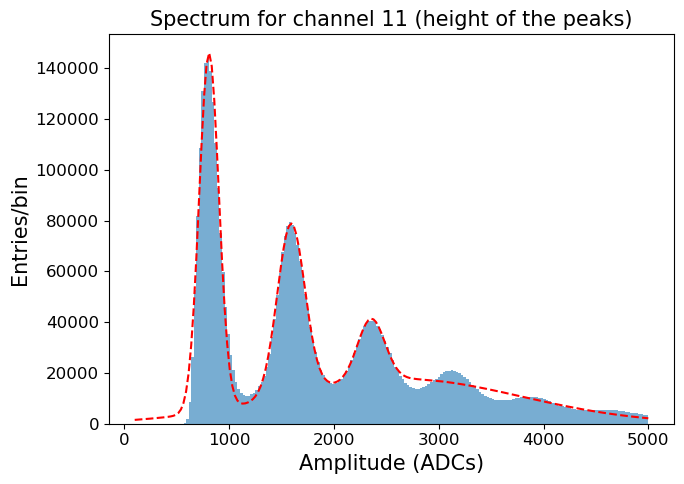

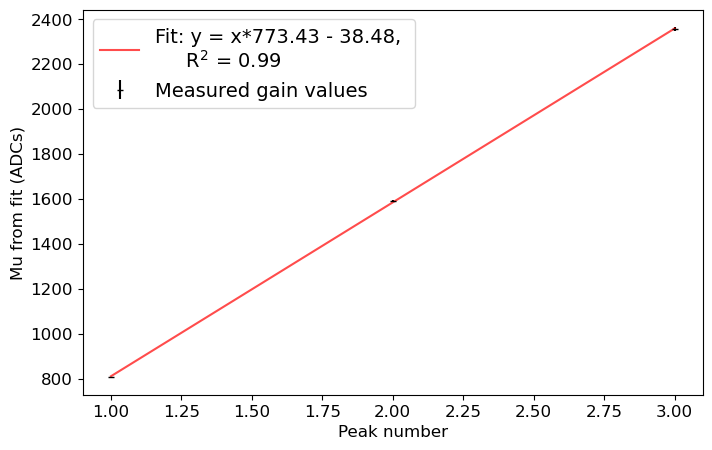

In [159]:
initial_guess_all_dates_ch9 = [170000, 800, 100, 100000, 1600, 150, 50000, 2370, 200, 25000, 3150, 180]
ch_vals        = np.concatenate(([h_peak_sg_d_trigg2_ch9_test[date] for date in all_dates]))
slope_ch9_test = fitf.fit_spectrum_and_plot(ch_vals, channel=k, bins=200, initial_guess=initial_guess_all_dates_ch9, rng=(100, 5000), num_peaks_fit=3)


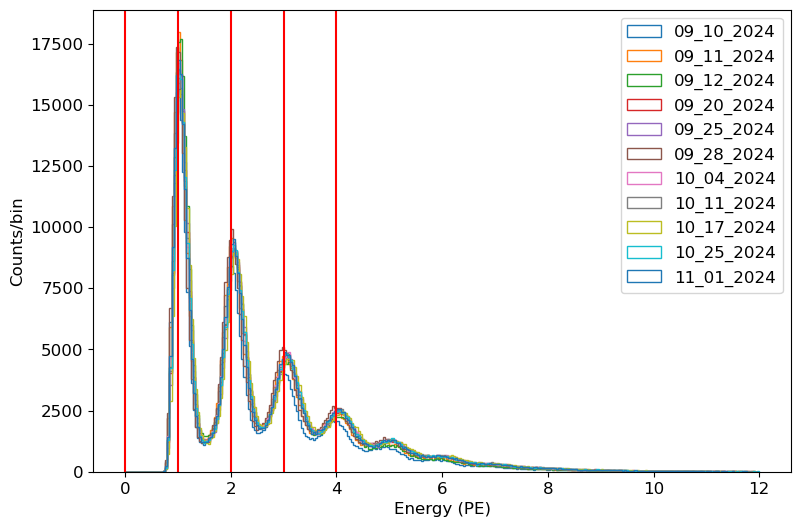

In [163]:
for date in all_dates:
    plt.hist(h_peak_sg_d_trigg2_ch9_test[date]/slope_ch9_test, 300, range=(0, 12), histtype='step', label=date)
    
for x in range(5):
    plt.axvline(x, color='r')
plt.xlabel('Energy (PE)')
plt.ylabel('Counts/bin')
plt.legend()
plt.show()